In [31]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
from xlayers import finegrid, layers
from xlayers.core import layers_apply
import numpy as np
from MITgcmutils import jmd95
import time as time

In [342]:
#load mitgcm output where \kappa_{redi}=50 (modern)
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer'
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer_skewflux_modGMdiagnose'
#iters=[152452800]
iters=[134308848]
prefixes=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GMRediTensor']
dsGM2x=xmitgcm.open_mdsdataset(datadir,prefix=prefixes,iters=iters)
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drF', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(dsGM2x, periodic=['X'], metrics=metrics)
dsGM2x.assign(GM_Age_r=dsGM2x.GM_Age_r*2)
dsGM2x.assign(GM_Age_x=dsGM2x.GM_Age_x*2)
dsGM2x.assign(GM_Age_y=dsGM2x.GM_Age_y*2)



<xarray.Dataset>
Dimensions:               (time: 1, XC: 60, YC: 144, XG: 60, YG: 144, Z: 30,
                           Zp1: 31, Zu: 30, Zl: 30, layer_1RHO_bounds: 435,
                           layer_1RHO_center: 434, layer_1RHO_interface: 433)
Coordinates: (12/33)
    iter                  (time) int64 134308848
  * time                  (time) timedelta64[ns] 1554 days 12:00:48
  * XC                    (XC) >f4 0.5 1.5 2.5 3.5 4.5 ... 56.5 57.5 58.5 59.5
  * YC                    (YC) >f4 -71.5 -70.5 -69.5 -68.5 ... 69.5 70.5 71.5
  * XG                    (XG) >f4 0.0 1.0 2.0 3.0 4.0 ... 56.0 57.0 58.0 59.0
  * YG                    (YG) >f4 -72.0 -71.0 -70.0 -69.0 ... 69.0 70.0 71.0
    ...                    ...
    maskW                 (Z, YC, XG) bool dask.array<chunksize=(30, 144, 60), meta=np.ndarray>
    maskS                 (Z, YG, XC) bool dask.array<chunksize=(30, 144, 60), meta=np.ndarray>
    rhoRef                (Z) >f4 1.028e+03 1.028e+03 ... 1.044e+03 1.045e+03
  * layer_1RHO_bounds     (layer_1RHO_bounds) >f4 1.0 10.0 20.0 ... 37.99 38.0
  * layer_1RHO_center     (layer_1RHO_center) float32 5.5 15.0 ... 37.99 38.0
  * layer_1RHO_interface  (layer_1RHO_interface) >f4 10.0 20.0 ... 37.98 37.99
Data variables: (12/29)
    uVeltave              (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    Tdiftave              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    ADVrTr01              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    ADVxTr01              (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    ADVyTr01              (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    DFrETr01              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    ...                    ...
    wVeltave              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    vVeltave              (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Age_x              (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Age_y              (time, Z, YG, XC) float32 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Age_r              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    Ttave                 (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[1...

In [137]:
#
modifiedGMTensor=True
if modifiedGMTensor is True:
    Kgm=1000
    Kredi=500
    GM_Kuz_gm=-dsGM2x.GM_Kuz.mean('time')*Kgm
    GM_Kvy_gm=-dsGM2x.GM_Kvy.mean('time')*Kgm
    GM_Kwx_gm=dsGM2x.GM_Kwx.mean('time')*Kgm
    GM_Kwy_gm=dsGM2x.GM_Kwy.mean('time')*Kgm
    
    
else:
    Kgm=1000
    Kredi=500
    GM_Kuz_gm=dsGM2x.GM_Kuz.mean('time')*Kgm/(Kgm-Kredi)
    GM_Kvy_gm=dsGM2x.GM_Kvy.mean('time')*Kgm/(Kgm-Kredi)
    GM_Kwx_gm=dsGM2x.GM_Kwx.mean('time')*Kgm/(Kgm+Kredi)
    GM_Kwy_gm=dsGM2x.GM_Kwy.mean('time')*Kgm/(Kgm+Kredi)
#fGMx_cgrid=GM_Kux_gm*

In [382]:
maskr=grid.interp(dsGM2x.maskC.astype('double'),'Z')
maskc=dsGM2x.maskC
maskr.load().data
maskr=maskr.where(maskr>0.5)
maskr=maskr.fillna(0)
PsixGM_Tensor=grid.interp(GM_Kwx_gm*dsGM2x.rA,'X')/dsGM2x.rAw
delPsixGM_Tensor=grid.diff(PsixGM_Tensor,'Z')
ugmFromTensor=delPsixGM_Tensor/dsGM2x.drF*dsGM2x.hFacW
PsiyGM_Tensor=grid.interp(GM_Kwy_gm*dsGM2x.rA,'Y')/dsGM2x.rAs
delPsiyGM_Tensor=grid.diff(PsiyGM_Tensor,'Z')
vgmFromTensor=delPsiyGM_Tensor/dsGM2x.drF*dsGM2x.hFacS
wgmFromTensor=grid.diff(PsixGM_Tensor,'X',boundary='periodic')/grid.diff(dsGM2x.XG,'X',boundary='periodic')\
    +grid.diff(PsiyGM_Tensor,'Y')/grid.diff(dsGM2x.YG,'Y')
wgmFromTensor=maskr*wgmFromTensor



In [340]:
age=dsGM2x.PTRtave01
age=age.where(dsGM2x.maskC).mean('time')
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
AgerfluxGM=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time')
wgmFromSkewflux=AgerfluxGM/agel/dsGM2x.rA
wgmAgeFromTensor=agel*wgmFromTensor*dsGM2x.rA
#age at U points(XG)
ageU=grid.interp(age,'X')
AgexfluxGM=dsGM2x.GM_Age_x.where(dsGM2x.ADVxTr01!=0).mean('time')
xA=dsGM2x.dyG*dsGM2x.drF
ugmAgeFromTensor=ageU*ugmFromTensor*xA
ugmFromSkewflux=AgexfluxGM/ageU/xA
#age at V points(YG)
ageV=grid.interp(age,'Y',boundary='fill')
AgeyfluxGM=dsGM2x.GM_Age_y.where(dsGM2x.ADVyTr01!=0).mean('time')
yA=dsGM2x.dxG*dsGM2x.drF
vgmAgeFromTensor=ageV*vgmFromTensor*yA
vgmFromSkewflux=AgeyfluxGM/ageV/yA

In [341]:
wgmFromTensor.sum('XC').sum('YC').load()

<xarray.DataArray (Zl: 30)>
array([ 0.        ,  0.08083706,  8.15118804, 10.47175049, 11.24813919,
       11.48611003, 10.70018099, 11.59306234, 15.9209441 , 19.38311651,
       19.63995033, 17.55363865, 19.42710105, 13.87685268, 15.42396229,
       32.82593855, 20.55084738, 19.30939164, 20.21439911, 13.90633054,
       11.65136534,  7.15194061,  5.88829412,  3.33075888,  4.20807388,
       -3.68302546, -4.64756923,  0.52839699,  8.68305313,  3.55395607])
Coordinates:
  * Zl       (Zl) >f4 0.0 -20.0 -40.0 -60.0 ... -3.25e+03 -3.5e+03 -3.75e+03

In [336]:
wgmFromSkewflux.sum('XC').sum('YC').load()

<xarray.DataArray (Zl: 30)>
array([ 0.0000000e+00, -1.1935065e-04, -4.5297333e-04, -2.4394001e-04,
       -2.4156623e-04, -3.8209168e-04,  1.5143059e-04,  2.6990165e-04,
       -2.7620255e-03,  9.2106353e-04,  1.1471882e-03,  7.4834959e-04,
        9.6297392e-04,  1.3885120e-03,  1.4024765e-03,  1.5260521e-03,
        9.0472528e-04,  8.7095681e-04,  7.5138186e-04,  8.0045220e-04,
        4.0323962e-04, -9.5753587e-04,  1.7053707e-04,  1.7934229e-04,
       -9.6058357e-05, -1.4843920e-04,  3.6461002e-05,  1.2918648e-04,
        1.4279300e-04,  1.2834511e-04], dtype=float32)
Coordinates:
  * Zl       (Zl) >f4 0.0 -20.0 -40.0 -60.0 ... -3.25e+03 -3.5e+03 -3.75e+03

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


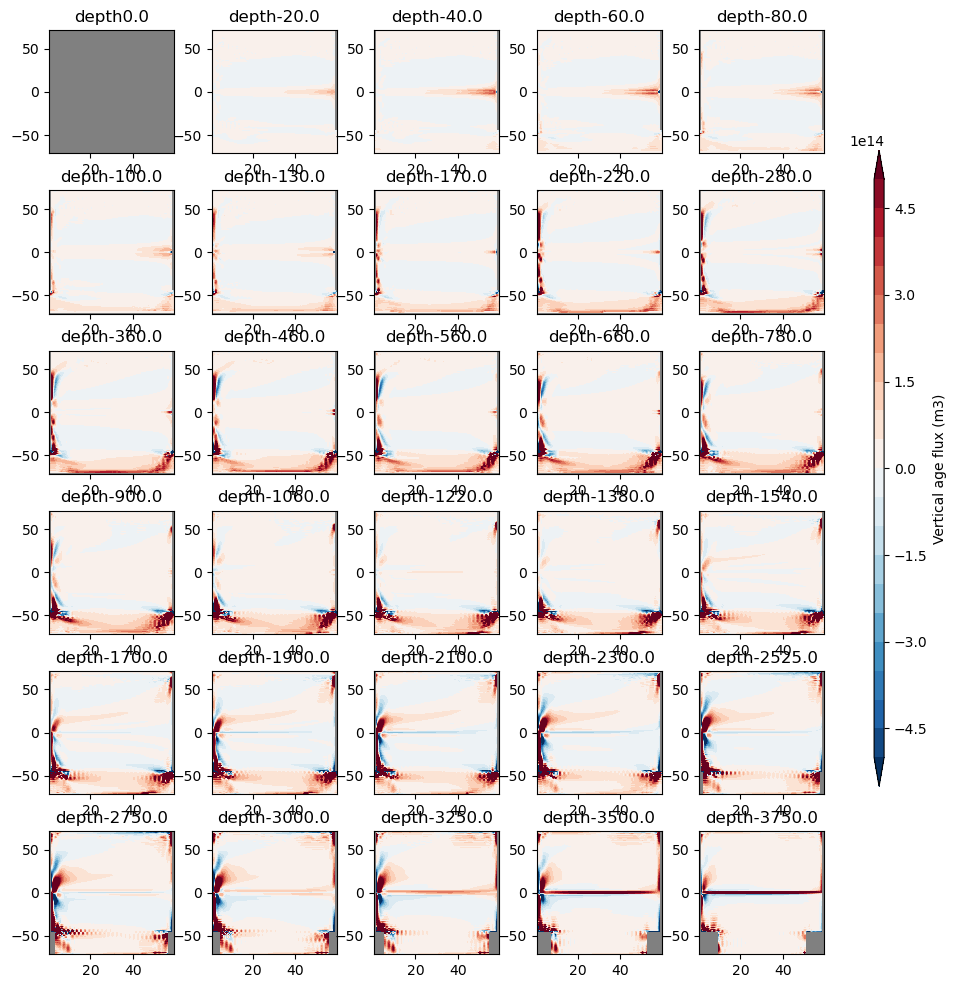

In [7]:
#visualize vertical age advection
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
   
    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='Vertical age flux (m3)')
    

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


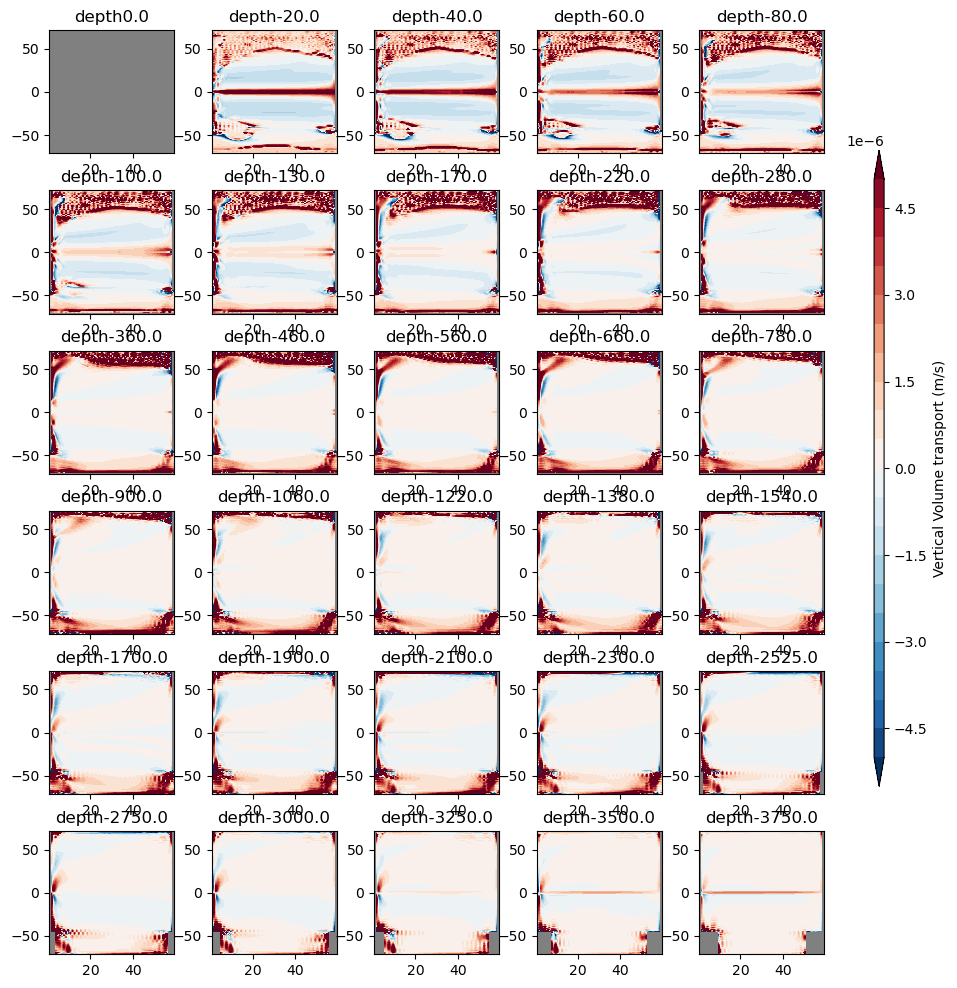

In [8]:
#visualize vertical age advection
wVolume=((dsGM2x.wVeltave+wGM)).where(dsGM2x.wVeltave!=0)
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    im=wVolume.isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e-6,add_colorbar=False,extend='both')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='Vertical Volume transport (m/s)')

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


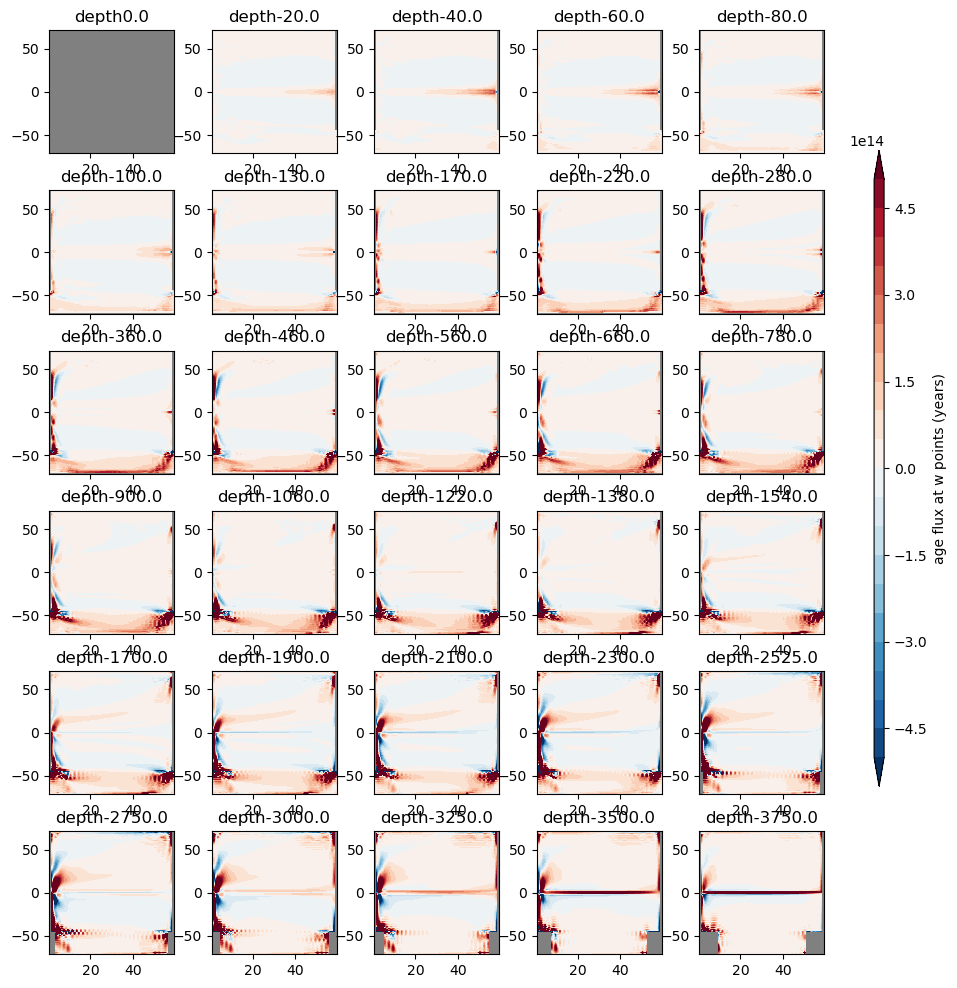

In [9]:
age=age.where(age!=0)
wVolume=((dsGM2x.wVeltave+wGM)*dsGM2x.rA).where(dsGM2x.wVeltave!=0)

myvageflux=agel*wVolume
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(myvageflux).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='age flux at w points (years)')

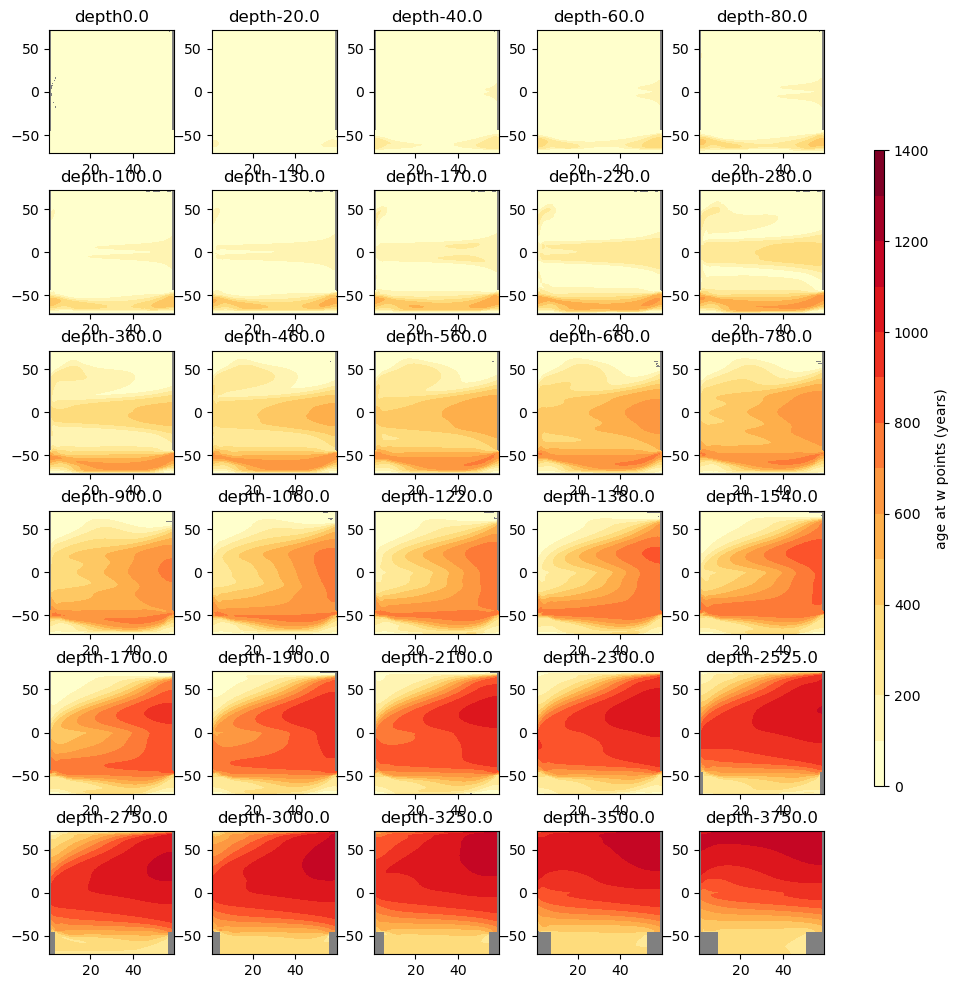

In [10]:
age=dsGM2x.PTRtave01
age=age.where(age!=0)
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(agel/31104000).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(0,1450,100),add_colorbar=False,extend='neither',cmap=plt.cm.YlOrRd)

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='age at w points (years)')

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


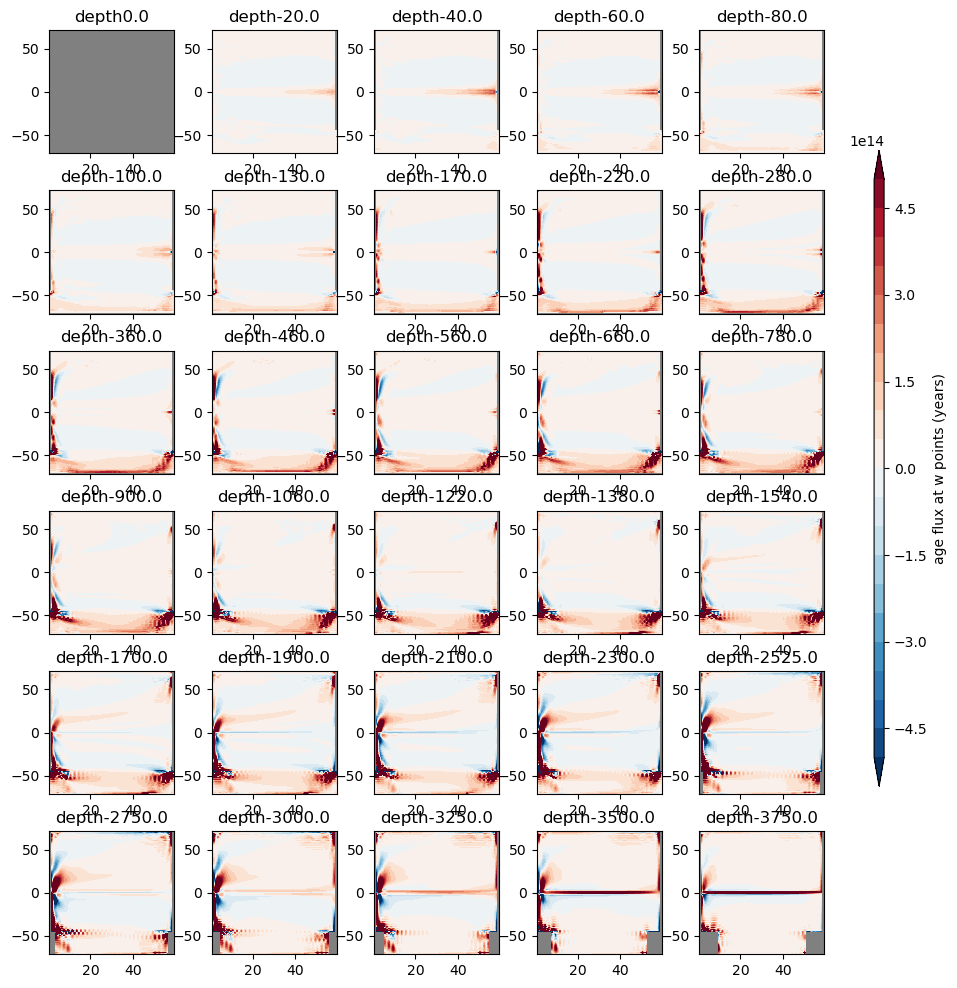

In [11]:
GM_x=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time');
GM_y=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time');
GM_r=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time');


age=age.where(age!=0)
wVolume=((dsGM2x.wVeltave+wGM)*dsGM2x.rA).where(dsGM2x.wVeltave!=0)

myvageflux=agel*wVolume
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(myvageflux).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='age flux at w points (years)')

In [12]:
from scipy.stats import gaussian_kde
def dens4scatter_kde(x,y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    return z

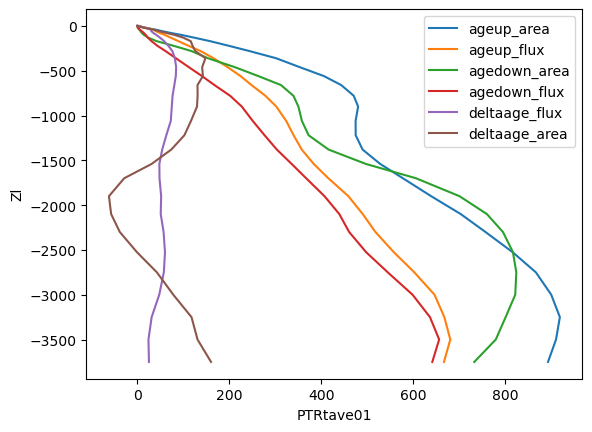

In [13]:
agetmean=agel.mean('time')/31104000
wVolume=(dsGM2x.wVeltave).where(dsGM2x.wVeltave!=0)
wVolumetmean=wVolume.mean('time')
wVolumepos=wVolumetmean.where(wVolumetmean>0)
agepos=agetmean.where(wVolumetmean>0)
wVolumeneg=wVolumetmean.where(wVolumetmean<0)
ageneg=agetmean.where(wVolumetmean<0)

agepos_areamean=grid.average(agepos,['X','Y'])
ageneg_areamean=grid.average(ageneg,['X','Y'])
agepos_fluxmean=grid.average(agepos*wVolumepos,['X','Y'])/grid.average(wVolumepos,['X','Y'])
ageneg_fluxmean=grid.average(ageneg*wVolumeneg,['X','Y'])/grid.average(wVolumeneg,['X','Y'])
deltaage_flux=-(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=-(ageneg_areamean-agepos_areamean)
agepos_areamean.plot(y='Zl',label='ageup_area')
agepos_fluxmean.plot(y='Zl',label='ageup_flux')
ageneg_areamean.plot(y='Zl',label='agedown_area')
ageneg_fluxmean.plot(y='Zl',label='agedown_flux')
deltaage_flux.plot(y='Zl',label='deltaage_flux')
deltaage_area.plot(y='Zl',label='deltaage_area')
plt.legend()



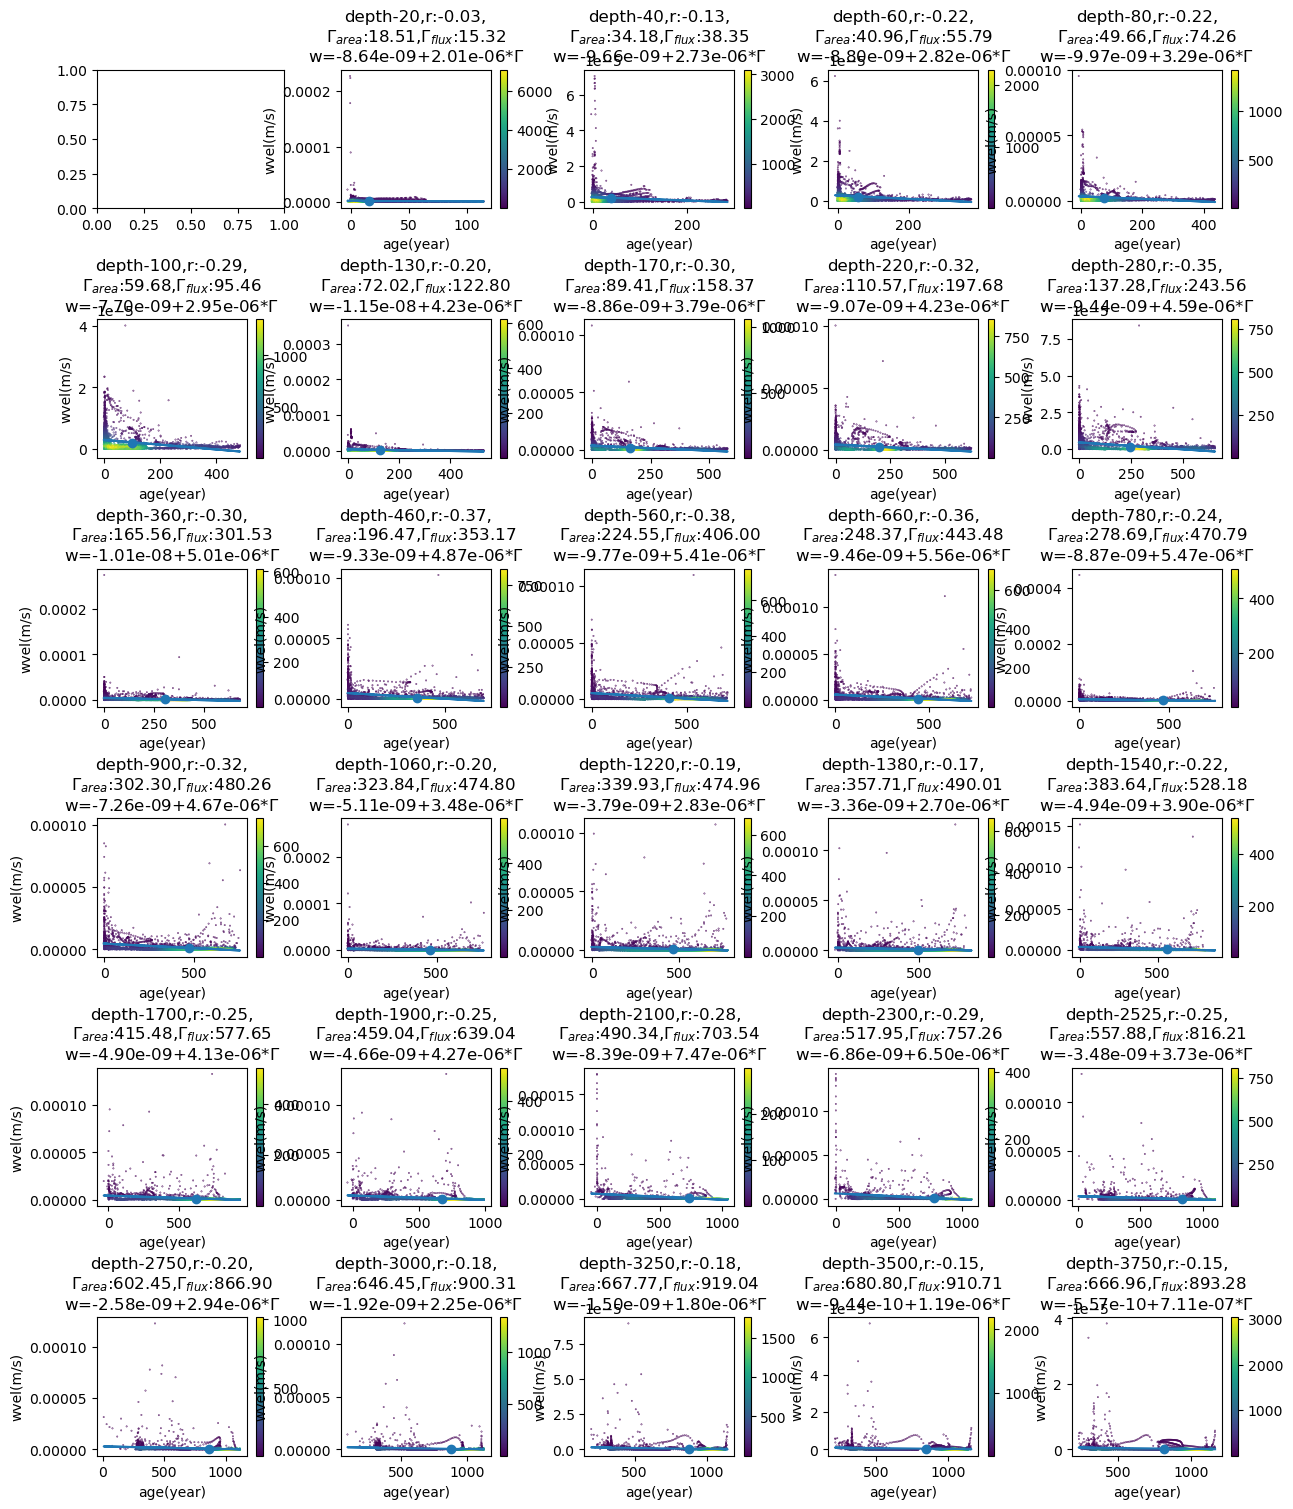

In [14]:
agetmean=agel.mean('time')/31104000
wVolume=(dsGM2x.wVeltave+wGM).where(dsGM2x.wVeltave!=0)
wVolumetmean=wVolume.mean('time')
wVolumepos=wVolumetmean.where(wVolumetmean>0)
agepos=agetmean.where(wVolumetmean>0)
wVolumeneg=wVolumetmean.where(wVolumetmean<0)
ageneg=agetmean.where(wVolumetmean<0)
fig = plt.figure(figsize=(15,18))
for i in range(0,30):
    
    plt.subplot(6,5, i+1)
    if i==0:
        continue
    xup=agepos.isel(Zl=i)
    xup=np.reshape(xup.load(),[1,144*60])
    xup=xup.data
    xup=xup[~np.isnan(xup)]
    yup=wVolumepos.isel(Zl=i)
    yup=np.reshape(yup,[1,144*60])
    yup=yup.data
    yup=yup[~np.isnan(yup)]
    zup=dens4scatter_kde(xup,yup)
    sc=plt.scatter(xup,yup,c=zup,s=0.1)
    plt.colorbar(sc)
    #plt.scatter(ageneg.isel(Zl=i),wVolumeneg.isel(Zl=i),s=0.1)
    xmean=grid.average(agepos.isel(Zl=i),['X','Y'])
    ymean=grid.average(wVolumepos.isel(Zl=i),['X','Y'])
    #plt.ylim(0,6*ymean ) 
    #plt.xlim(0,6*xmean ) 
    plt.scatter(xmean,ymean)
    fitcoef=np.polyfit(xup,yup,1)
    fiteq=np.poly1d(fitcoef)
    yfit=fiteq(xup)
    plt.plot(xup,yfit)
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",w=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",\n$\Gamma_{area}$:%.2f,$\Gamma_{flux}$:%.2f"%(agepos_fluxmean[i].load().data,agepos_areamean[i].load().data)+"\nw=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f\n")
    plt.xlabel('age(year)')
    plt.ylabel('wvel(m/s)')
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
     
fig.subplots_adjust(wspace=0.3,hspace=0.8)

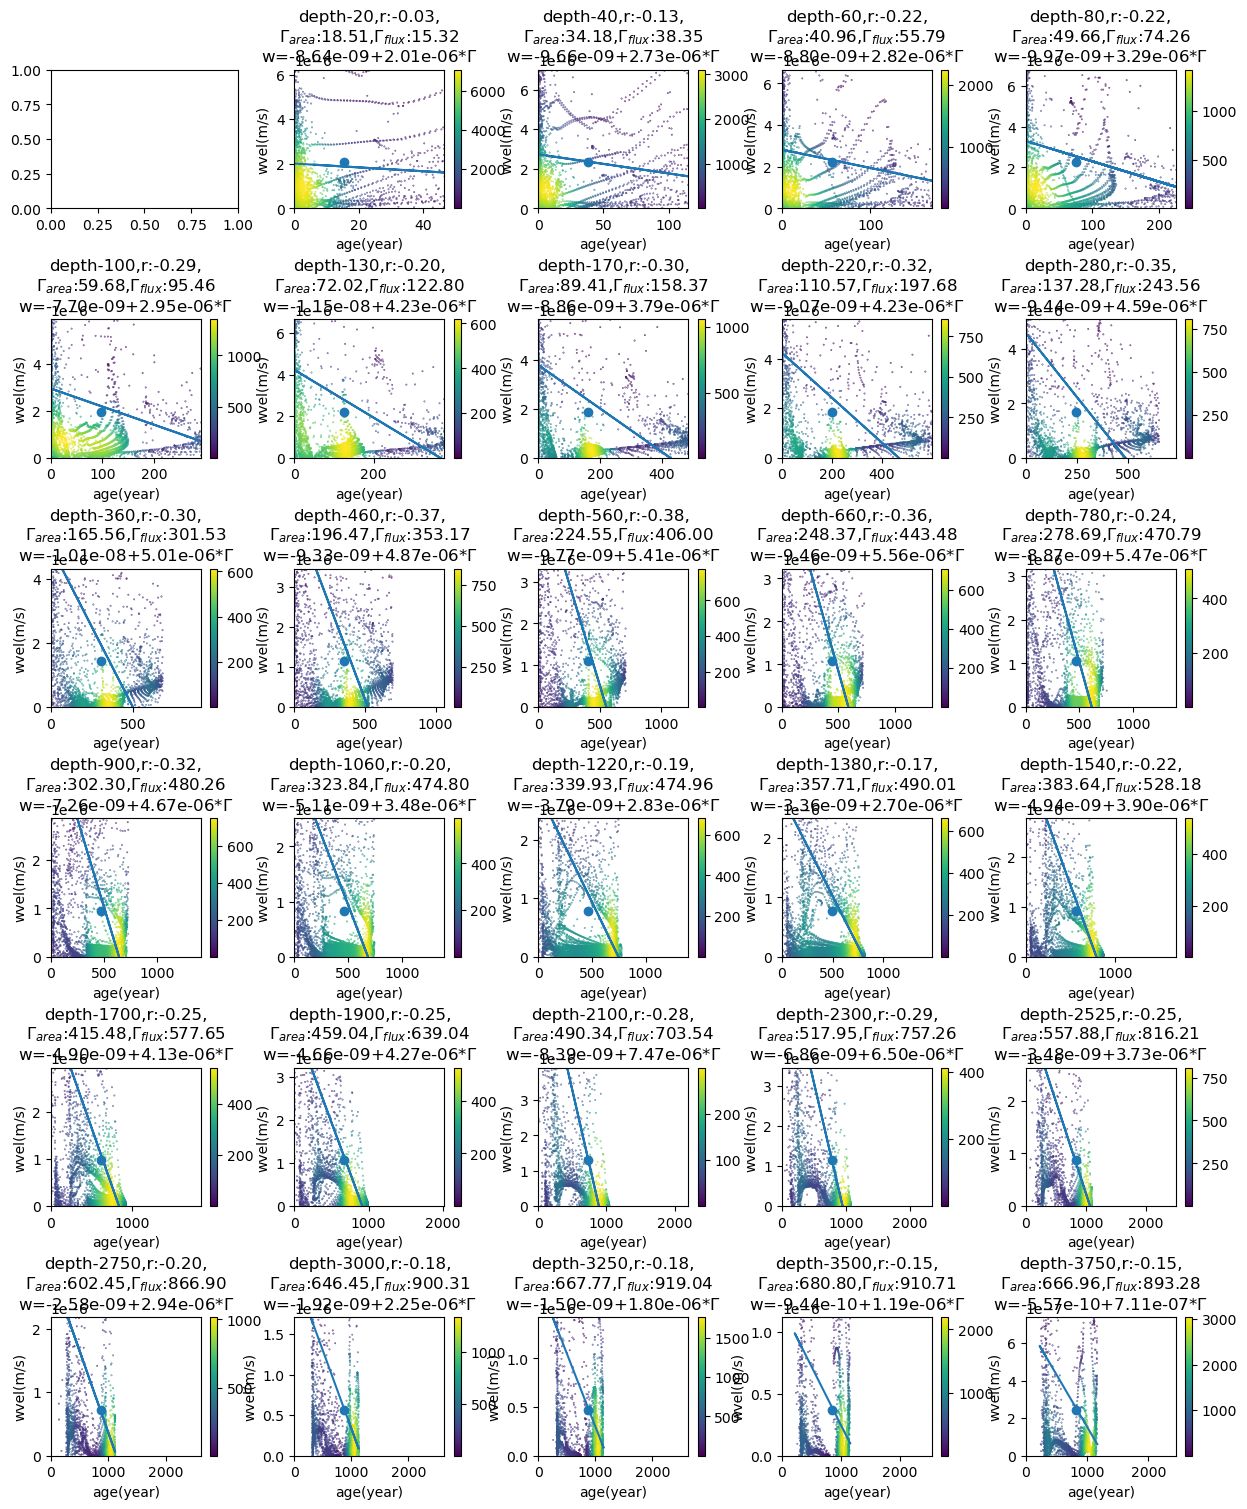

In [15]:
agetmean=agel.mean('time')/31104000
wVolume=(dsGM2x.wVeltave+wGM).where(dsGM2x.wVeltave!=0)
wVolumetmean=wVolume.mean('time')
wVolumepos=wVolumetmean.where(wVolumetmean>0)
agepos=agetmean.where(wVolumetmean>0)
wVolumeneg=wVolumetmean.where(wVolumetmean<0)
ageneg=agetmean.where(wVolumetmean<0)
fig = plt.figure(figsize=(15,18))
for i in range(0,30):
    
    plt.subplot(6,5, i+1)
    if i==0:
        continue
    xup=agepos.isel(Zl=i)
    xup=np.reshape(xup.load(),[1,144*60])
    xup=xup.data
    xup=xup[~np.isnan(xup)]
    yup=wVolumepos.isel(Zl=i)
    yup=np.reshape(yup,[1,144*60])
    yup=yup.data
    yup=yup[~np.isnan(yup)]
    zup=dens4scatter_kde(xup,yup)
    sc=plt.scatter(xup,yup,c=zup,s=0.1)
    plt.colorbar(sc)
    #plt.scatter(ageneg.isel(Zl=i),wVolumeneg.isel(Zl=i),s=0.1)
    xmean=grid.average(agepos.isel(Zl=i),['X','Y'])
    ymean=grid.average(wVolumepos.isel(Zl=i),['X','Y'])
    plt.ylim(0,3*ymean ) 
    plt.xlim(0,3*xmean ) 
    plt.scatter(xmean,ymean)
    fitcoef=np.polyfit(xup,yup,1)
    fiteq=np.poly1d(fitcoef)
    yfit=fiteq(xup)
    plt.plot(xup,yfit)
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",w=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",\n$\Gamma_{area}$:%.2f,$\Gamma_{flux}$:%.2f"%(agepos_fluxmean[i].load().data,agepos_areamean[i].load().data)+"\nw=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f\n")
    plt.xlabel('age(year)')
    plt.ylabel('wvel(m/s)')
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
     
fig.subplots_adjust(wspace=0.3,hspace=0.8)

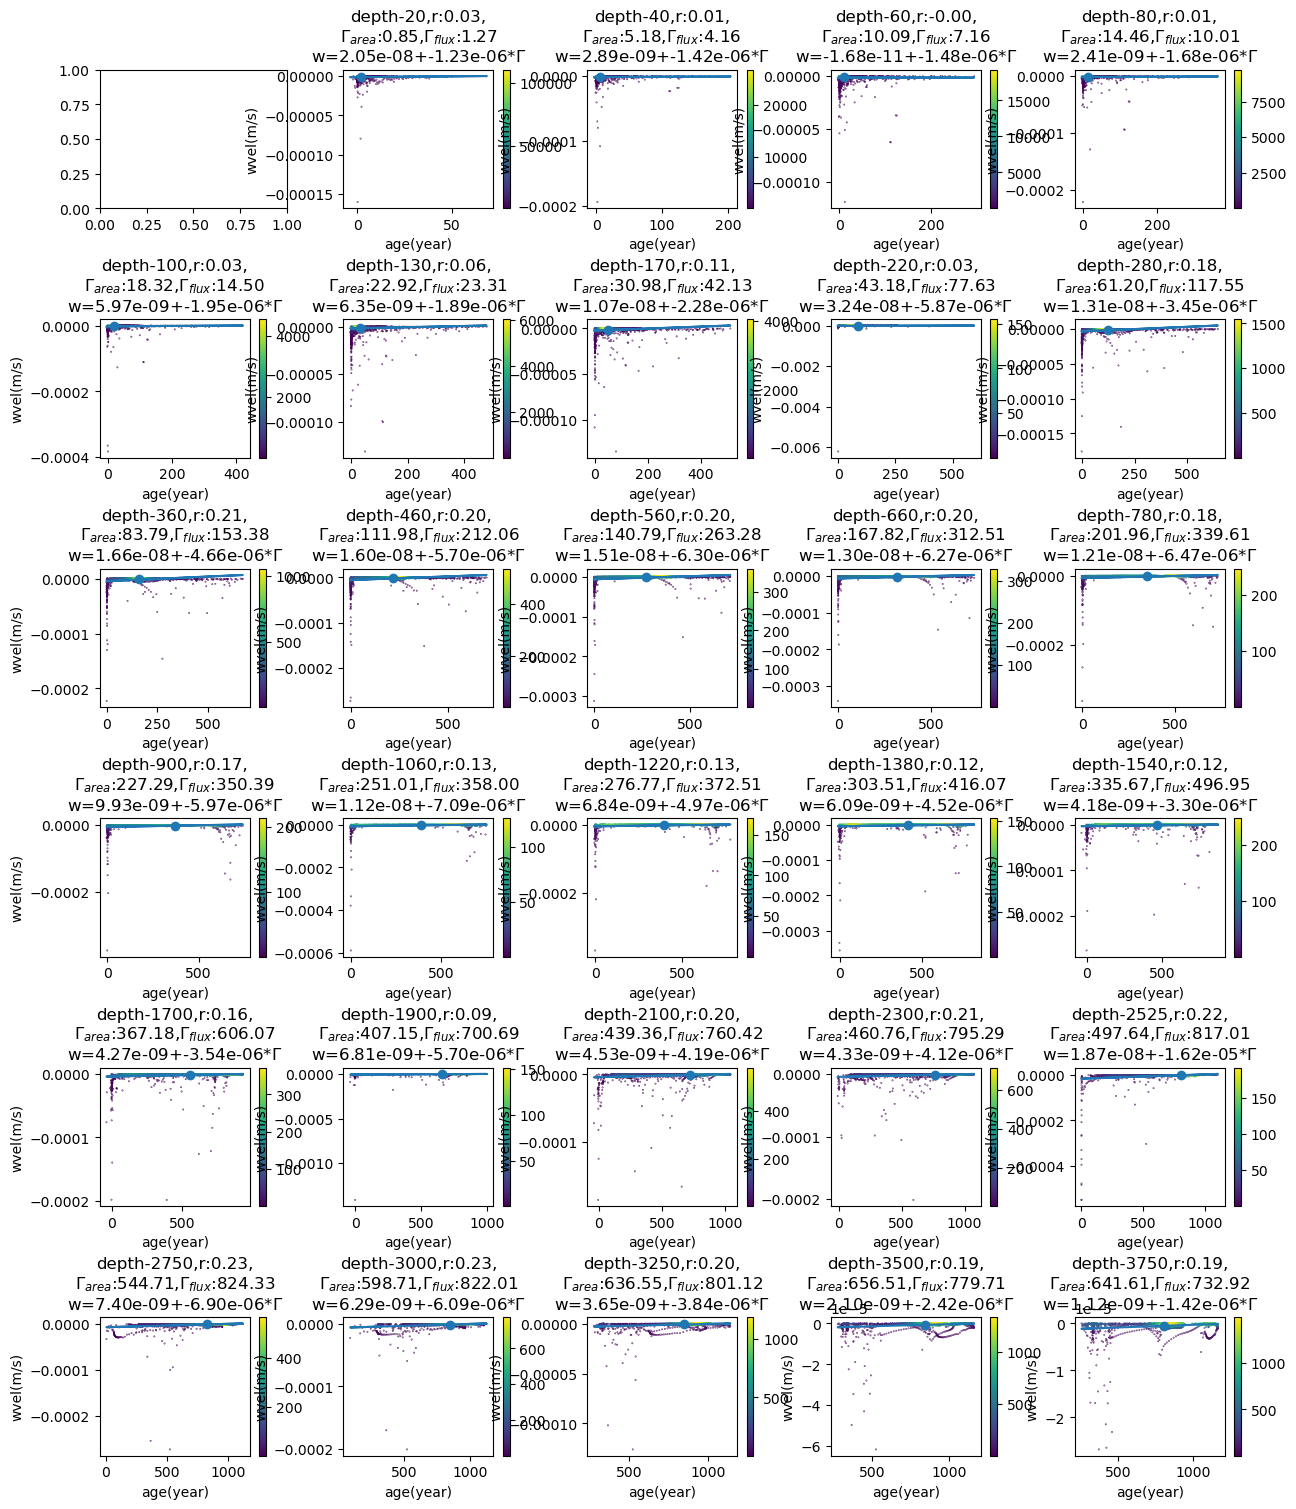

In [16]:
agetmean=agel.mean('time')/31104000
wVolume=(dsGM2x.wVeltave+wGM).where(dsGM2x.wVeltave!=0)
wVolumetmean=wVolume.mean('time')
wVolumepos=wVolumetmean.where(wVolumetmean>0)
agepos=agetmean.where(wVolumetmean>0)
wVolumeneg=wVolumetmean.where(wVolumetmean<0)
ageneg=agetmean.where(wVolumetmean<0)
fig = plt.figure(figsize=(15,18))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    if i==0:
        continue
    xup=ageneg.isel(Zl=i)
    xup=np.reshape(xup.load(),[1,144*60])
    xup=xup.data
    xup=xup[~np.isnan(xup)]
    yup=wVolumeneg.isel(Zl=i)
    yup=np.reshape(yup,[1,144*60])
    yup=yup.data
    yup=yup[~np.isnan(yup)]
    zup=dens4scatter_kde(xup,yup)
    sc=plt.scatter(xup,yup,c=zup,s=0.1)
    plt.colorbar(sc)
    #plt.scatter(ageneg.isel(Zl=i),wVolumeneg.isel(Zl=i),s=0.1)
    xmean=grid.average(ageneg.isel(Zl=i),['X','Y'])
    ymean=grid.average(wVolumeneg.isel(Zl=i),['X','Y'])
    #plt.ylim(3*ymean,0 ) 
    #plt.xlim(0,3*xmean) 
    plt.scatter(xmean,ymean)
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
    fitcoef=np.polyfit(xup,yup,1)
    fiteq=np.poly1d(fitcoef)
    yfit=fiteq(xup)
    plt.plot(xup,yfit)
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",w=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",\n$\Gamma_{area}$:%.2f,$\Gamma_{flux}$:%.2f"%(ageneg_fluxmean[i].load().data,ageneg_areamean[i].load().data)+"\nw=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f\n")
    plt.xlabel('age(year)')
    plt.ylabel('wvel(m/s)')
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
     
fig.subplots_adjust(wspace=0.3,hspace=0.8)
     
#fig.subplots_adjust(wspace=0.3,hspace=0.3)

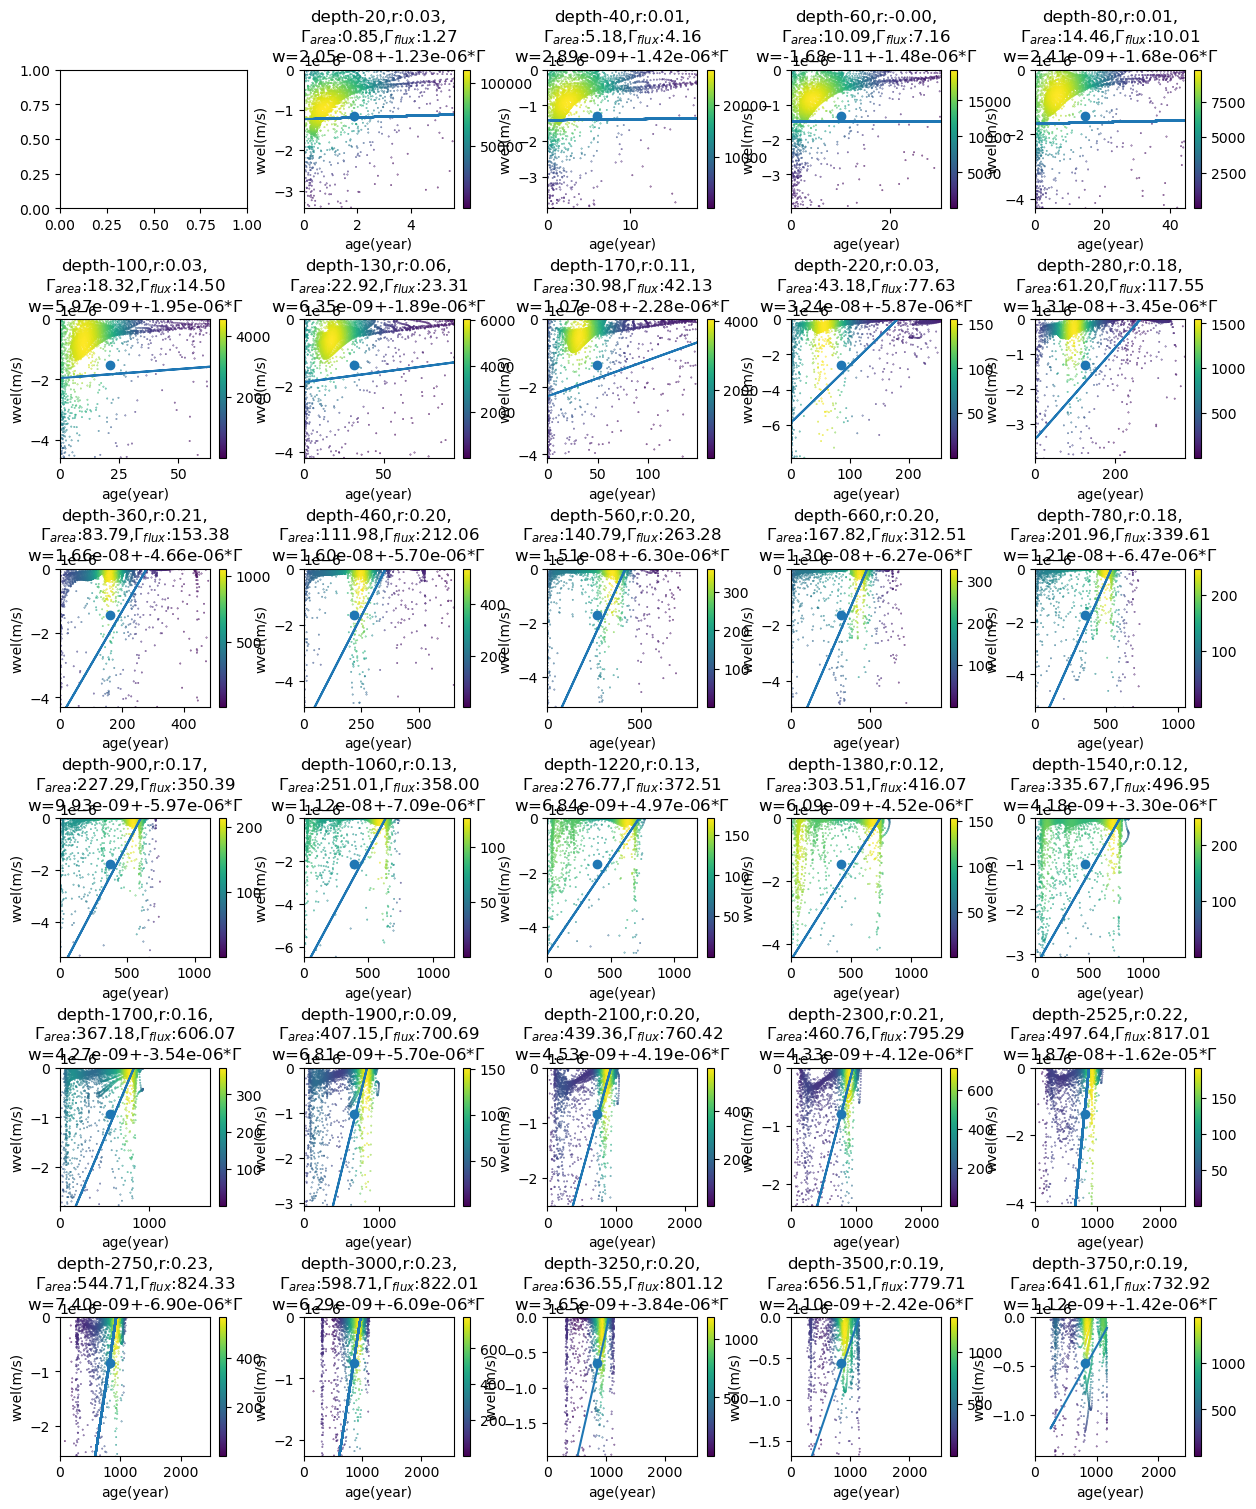

In [17]:
agetmean=agel.mean('time')/31104000
wVolume=(dsGM2x.wVeltave+wGM).where(dsGM2x.wVeltave!=0)
wVolumetmean=wVolume.mean('time')
wVolumepos=wVolumetmean.where(wVolumetmean>0)
agepos=agetmean.where(wVolumetmean>0)
wVolumeneg=wVolumetmean.where(wVolumetmean<0)
ageneg=agetmean.where(wVolumetmean<0)
fig = plt.figure(figsize=(15,18))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    if i==0:
        continue
    xup=ageneg.isel(Zl=i)
    xup=np.reshape(xup.load(),[1,144*60])
    xup=xup.data
    xup=xup[~np.isnan(xup)]
    yup=wVolumeneg.isel(Zl=i)
    yup=np.reshape(yup,[1,144*60])
    yup=yup.data
    yup=yup[~np.isnan(yup)]
    zup=dens4scatter_kde(xup,yup)
    sc=plt.scatter(xup,yup,c=zup,s=0.1)
    plt.colorbar(sc)
    #plt.scatter(ageneg.isel(Zl=i),wVolumeneg.isel(Zl=i),s=0.1)
    xmean=grid.average(ageneg.isel(Zl=i),['X','Y'])
    ymean=grid.average(wVolumeneg.isel(Zl=i),['X','Y'])
    plt.ylim(3*ymean,0 ) 
    plt.xlim(0,3*xmean) 
    plt.scatter(xmean,ymean)
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
    fitcoef=np.polyfit(xup,yup,1)
    fiteq=np.poly1d(fitcoef)
    yfit=fiteq(xup)
    plt.plot(xup,yfit)
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",w=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f"%np.corrcoef(xup,yup)[0,1]+",\n$\Gamma_{area}$:%.2f,$\Gamma_{flux}$:%.2f"%(ageneg_fluxmean[i].load().data,ageneg_areamean[i].load().data)+"\nw=%.2e+%.2e*$\Gamma$"%(fitcoef[0],fitcoef[1]))
    #plt.title("depth%d"%dsGM2x.Zl[i].data+",r:%.2f\n")
    plt.xlabel('age(year)')
    plt.ylabel('wvel(m/s)')
    #plt.scatter(grid.average(ageneg.isel(Zl=i),['X','Y']),wVolumeneg.isel(Zl=i).mean('XC').mean('YC'))
     
fig.subplots_adjust(wspace=0.3,hspace=0.8)
     
#fig.subplots_adjust(wspace=0.3,hspace=0.3)

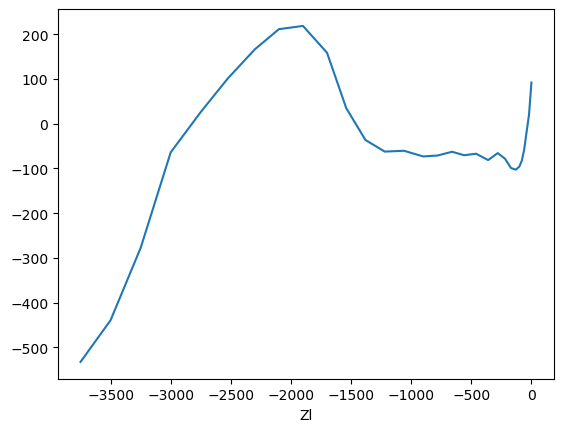

In [18]:
deltaage_flux=(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=(ageneg_areamean-agepos_areamean)
((deltaage_flux-deltaage_area)/deltaage_flux*100).plot()

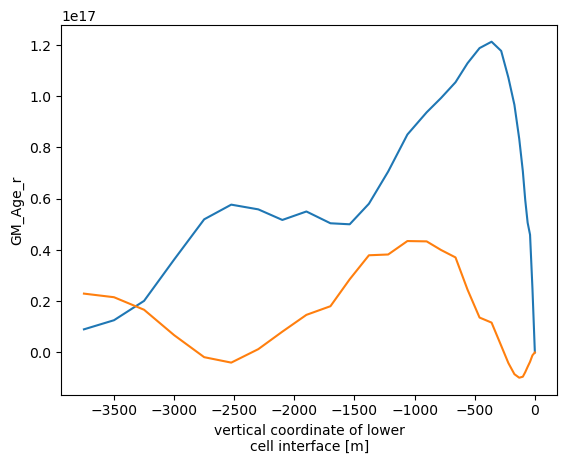

In [343]:
ADVrage=dsGM2x.ADVrTr01.mean('time').sum('XC').sum('YC')
GMrage=dsGM2x.GM_Age_r.mean('time').sum('XC').sum('YC')
DFrEage=dsGM2x.DFrETr01.mean('time').sum('XC').sum('YC')
DFrIage=dsGM2x.DFrITr01.mean('time').sum('XC').sum('YC')
ADVrage.plot()
GMrage.plot()

In [344]:
testarray=dsGM2x.ADVrTr01.mean('time')
testarray[[1,2],[1,2],[1,2,-1]]

<xarray.DataArray 'ADVrTr01' (Zl: 2, YC: 2, XC: 3)>
dask.array<getitem, shape=(2, 2, 3), dtype=float32, chunksize=(2, 2, 3), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 1.5 2.5 59.5
  * YC       (YC) >f4 -70.5 -69.5
  * Zl       (Zl) >f4 -20.0 -40.0
    rA       (YC, XC) >f4 dask.array<chunksize=(2, 3), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(2, 3), meta=np.ndarray>

<a list of 13 text.Text objects>

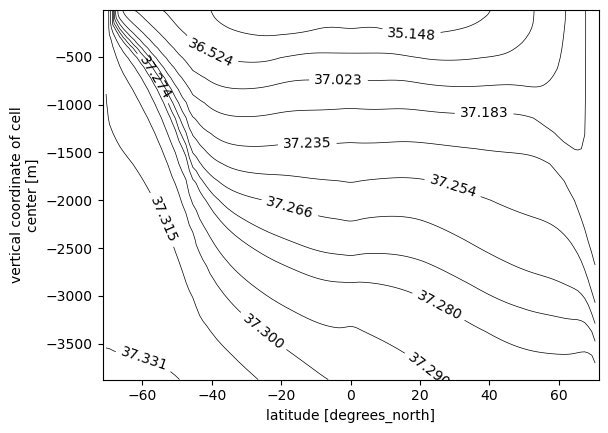

In [345]:
rhoConst=1035
locPres=dsGM2x.PHrefC*rhoConst
locPres
Stave=dsGM2x.Stave.mean('time')
Ttave=dsGM2x.Ttave.mean('time')
locPres3D=locPres.broadcast_like(Stave)
Stave=Stave.where(Stave!=0)
rho3D=jmd95.densjmd95(Stave,Ttave,locPres3D/10000)
rho3D=jmd95.densjmd95(Stave,Ttave,2000)
rho3D=0*Stave+rho3D
#rhoAnoma=dsGM2x.RHOAnoma.mean('time')+0*Stave

layers1_bounds=[
29,
32,
34,
35.1475019431067,
35.7606867402774,
36.1967377768488,
36.5241586336697,
36.7535664519388,
36.9136106471677,
37.0225096344218,
37.0963264098645,
37.1468671450582,
37.1834441418816,
37.2068170992221,
37.2227259810384,
37.2349249974977,
37.2425252313368,
37.2490123001663,
37.2543862039861,
37.2586586838667,
37.2627128227654,
37.2659033167649,
37.2690102073597,
37.2713646673121,
37.2736936223893,
37.2757930335893,
37.2778924447893,
37.2798996483998,
37.2819044877131,
37.2838965074870,
37.2858836646769,
37.2878550801339,
37.2897972609441,
37.2917394417543,
37.2935546684733,
37.2953474915292,
37.2970608808460,
37.2986267503616,
37.3001926198771,
37.3015729834645,
37.3029206107117,
37.3049206107117,
37.3069206107117,
37.3089206107117,
37.3109206107117,
37.3129206107117,
37.3149206107117,
37.3169206107117,
37.3189206107117,
37.3209206107117,
37.3229206107117,
37.3249206107117,
37.3269206107117,
37.3289206107117,
37.3309206107117,
37.3329206107117,
37.3409206107117,
37.3509206107117,
37.3609206107117,
37.3659206107117,
]

layers1_bounds=[
29,
32,
34,
35.1475019431067,
35.7606867402774,
36.1967377768488,
36.5241586336697,
36.7535664519388,
36.9136106471677,
37.0225096344218,
37.0963264098645,
37.1468671450582,
37.1834441418816,
37.2068170992221,
37.2227259810384,
37.2349249974977,
37.2425252313368,
37.2490123001663,
37.2543862039861,
37.2586586838667,
37.2627128227654,
37.2659033167649,
37.2690102073597,
37.2713646673121,
37.2736936223893,
37.2757930335893,
37.2778924447893,
37.2798996483998,
37.2819044877131,
37.2838965074870,
37.2858836646769,
37.2878550801339,
37.2897972609441,
37.2917394417543,
37.2935546684733,
37.2953474915292,
37.2970608808460,
37.2986267503616,
37.3001926198771,
37.3015729834645,
37.3029206107117,
37.3049206107117,
37.3069206107117,
37.3089206107117,
37.3109206107117,
37.3129206107117,
37.3149206107117,
37.3169206107117,
37.3189206107117,
37.3209206107117,
37.3229206107117,
37.3249206107117,
37.3269206107117,
37.3289206107117,
37.3309206107117,
37.3329206107117,
37.3409206107117,
37.3509206107117,
37.3609206107117,
37.3659206107117,
]
layers1_bounds=layers1_bounds[:25:3]+layers1_bounds[27:35:5]+layers1_bounds[38::8]
#layers1_bounds=np.linspace(20,46,30)-35
CS=(rho3D-1000).mean('XC').plot.contour(levels=layers1_bounds,linewidths=0.5, colors='k')
#CS2=rhoAnoma.mean('XC').plot.contour(levels=layers1_bounds,linewidths=0.1, colors='b')
plt.clabel(CS, inline=True, fontsize=10)
#plt.clabel(CS2, inline=True, fontsize=5)

In [346]:
layers1_bounds

[29,
 35.1475019431067,
 36.5241586336697,
 37.0225096344218,
 37.1834441418816,
 37.2349249974977,
 37.2543862039861,
 37.2659033167649,
 37.2736936223893,
 37.2798996483998,
 37.2897972609441,
 37.3001926198771,
 37.3149206107117,
 37.3309206107117]

In [347]:
agetmean=dsGM2x.PTRtave01.mean('time').where(dsGM2x.maskC)

agezgrad=grid.diff(agetmean,'Z',boundary='fill')
agexgrad=grid.diff(agetmean,'X')
ageygrad=grid.diff(agetmean,'Y',boundary='fill')

drCl=grid.diff(dsGM2x.Z,'Z',boundary='fill')
agezgrad=agezgrad/drCl


In [348]:
#divADV=
#divRedi=
#divGM=
#divkiso=
#divkdia=
diffKrBL79surf=2e-5;
diffKrBL79deep= 1e-4;
diffKrBL79Ho  = -2000;
diffKrBL79scl = 150;
Z3d=0*dsGM2x.wVeltave.mean('time')+dsGM2x.Zl
kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
kappa=dsGM2x.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
GM_Kwz=dsGM2x['GM_Kwz-T'].mean('time')
#fractions of different fluxes
frac_dia=kdia3d/kappa
frac_GM_Kwz=GM_Kwz/kappa
frac_conv=1-frac_dia-frac_GM_Kwz
#

fadvx=dsGM2x.ADVxTr01.mean('time')
fdiffx=dsGM2x.DFxETr01.mean('time') #GM-Redi x age flux
fadvy=dsGM2x.ADVyTr01.mean('time')
fdiffy=dsGM2x.DFyETr01.mean('time') #GM-Redi y age flux
fadvr=dsGM2x.ADVrTr01.mean('time')
fdiffrE=dsGM2x.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
fdiffrI=dsGM2x.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv

#GM age flux
fGMx=dsGM2x.GM_Age_x.mean('time')
fGMy=dsGM2x.GM_Age_y.mean('time')
fGMr=dsGM2x.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
#Redi age flux
fRedix=fdiffx-fGMx
#fRedix=0*dsGM2x.Redi_ax.mean('time')
fRediy=fdiffy-fGMy
#fRediy=0*dsGM2x.Redi_ay.mean('time')
fRedirE=fdiffrE-fGMr#
#fRedirE=-0*dsGM2x.Redi_ar.mean('time')#only contribution of Kwx and Kwy


#separating implicit diffusion: kdia+GM_Kwz+kconv
fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
fdia=fdiffrI*frac_dia
fconv=fdiffrI*frac_conv

#Redi r term
fRedir=fRedirE+fRedirI


ftotx=fadvx+fdiffx
ftoty=fadvy+fdiffy
ftotr=fadvr+fdiffrE+fdiffrI

fsurf=dsGM2x.ForcTr01.mean('time')*dsGM2x.rA*dsGM2x.drF
fsurf[1:,:,:]=0

Vol=dsGM2x.rA*dsGM2x.drF

##divtot diag
#divtotx_diag=dsGM2x.UDIAG1.mean('time')*Vol
#divtoty_diag=dsGM2x.UDIAG2.mean('time')*Vol
#divtotr_diag=dsGM2x.UDIAG3.mean('time')*Vol
#divtot_diag=divtotx_diag+divtoty_diag+divtotr_diag

def divflux(fx,fy,fr,grid=grid):
    '''
    return divergence of a certain flux
    '''
    divfx=grid.diff(fx,axis='X',boundary='periodic')
    divfy=grid.diff(fy,axis='Y',boundary='periodic')
    divfr=-grid.diff(fr,axis='Z',boundary='periodic')
    return divfx,divfy,divfr,divfx+divfy+divfr
#divtot
#divtotx=grid.diff(ftotx,axis='X',boundary='periodic')
#divtoty=grid.diff(ftoty,axis='Y',boundary='fill')
#divtotr=-grid.diff(ftotr,axis='Z',boundary='fill')
#divtot=divtotx+divtoty+divtotr
divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)


#div ADV flux: be careful on boundary condition, especially for diffusive fluxes
#divadvx=grid.diff(fadvx,axis='X',boundary='periodic')
#divadvy=grid.diff(fadvy,axis='Y',boundary='fill')
#divadvr=-grid.diff(ftotr,axis='Z',boundary='fill')
#divadv=divadvx+divadvy+divadvr
divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)

#div GM flux
divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)

#div Redi flux
divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)

#div dia flux
divdia=-grid.diff(fdia,axis='Z',boundary='periodic')
#div conv flux
divconv=-grid.diff(fconv,axis='Z',boundary='periodic')




In [349]:
'''
def findrhoindexgrid(rhoz,layers1_bounds):
    #print(rhoz)
    Nlayersbin=len(layers1_bounds)
    #print(Nlayersbin)
    rhoindexz=np.nan*rhoz
    #rhoindexz=rhoindexz.data
    #rhoz=rhoz.data
    #print(rhoindexz)
    
    rhotemp=rhoz-1000
    #print(rhotemp.load
    if np.isnan(rhotemp):
        return np.nan
    #rhoid_currentgrid=0
    for idrho in range(Nlayersbin):
        rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]
        if rhotemp<layers1_bounds[idrho]:
            
            break
    #print(rhoid_currentgrid)
    return rhoid_currentgrid

print(findrhoindexgrid(rho3D[2,2,2],layers1_bounds))
layers1_bounds_xr=xr.DataArray(layers1_bounds,dims=("layers1_bounds"))
start = time.time()
rhoindexxr=xr.apply_ufunc(
    findrhoindexgrid,
    #rho3D[2,2,2],
    rho3D,
    layers1_bounds_xr,
    vectorize=True,
    input_core_dims=[[],["layers1_bounds"]],
    #output_dtypes=[float],
)
end = time.time()
print(end - start)
rhoindexxr=rhoindexxr.rename('rhoindex3d')
'''

'\ndef findrhoindexgrid(rhoz,layers1_bounds):\n    #print(rhoz)\n    Nlayersbin=len(layers1_bounds)\n    #print(Nlayersbin)\n    rhoindexz=np.nan*rhoz\n    #rhoindexz=rhoindexz.data\n    #rhoz=rhoz.data\n    #print(rhoindexz)\n    \n    rhotemp=rhoz-1000\n    #print(rhotemp.load\n    if np.isnan(rhotemp):\n        return np.nan\n    #rhoid_currentgrid=0\n    for idrho in range(Nlayersbin):\n        rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]\n        if rhotemp<layers1_bounds[idrho]:\n            \n            break\n    #print(rhoid_currentgrid)\n    return rhoid_currentgrid\n\nprint(findrhoindexgrid(rho3D[2,2,2],layers1_bounds))\nlayers1_bounds_xr=xr.DataArray(layers1_bounds,dims=("layers1_bounds"))\nstart = time.time()\nrhoindexxr=xr.apply_ufunc(\n    findrhoindexgrid,\n    #rho3D[2,2,2],\n    rho3D,\n    layers1_bounds_xr,\n    vectorize=True,\n    input_core_dims=[[],["layers1_bounds"]],\n    #output_dtypes=[float],\n)\nend = time.time()\nprint(end -

In [350]:
'''
rhoindex=0*rho3D.load()
rho3Ddata=rho3D.load()
[Nz,Ny,Nx]=rhoindex.shape



for idx in range(Nx):
    start = time.time()
    for idy in range(Ny):     
        for idz in range(Nz):
            rhotemp=rho3Ddata[idz,idy,idx].load()-1000
            #print(rhotemp)
            if np.isnan(rhotemp):
                rhoindex[idz,idy,idx]=np.nan
                continue
            #rhoid_currentgrid=0
            for idrho in range(Nlayersbin):
                rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]
                
                if rhotemp<layers1_bounds[idrho]:
                    break
            #print(rhoid_currentgrid)
            rhoindex[idz,idy,idx]=rhoid_currentgrid
    end=time.time()
    print(end - start)
rhoindex
'''

'\nrhoindex=0*rho3D.load()\nrho3Ddata=rho3D.load()\n[Nz,Ny,Nx]=rhoindex.shape\n\n\n\nfor idx in range(Nx):\n    start = time.time()\n    for idy in range(Ny):     \n        for idz in range(Nz):\n            rhotemp=rho3Ddata[idz,idy,idx].load()-1000\n            #print(rhotemp)\n            if np.isnan(rhotemp):\n                rhoindex[idz,idy,idx]=np.nan\n                continue\n            #rhoid_currentgrid=0\n            for idrho in range(Nlayersbin):\n                rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]\n                \n                if rhotemp<layers1_bounds[idrho]:\n                    break\n            #print(rhoid_currentgrid)\n            rhoindex[idz,idy,idx]=rhoid_currentgrid\n    end=time.time()\n    print(end - start)\nrhoindex\n'

In [351]:

start = time.time()
Nlayersbin=len(layers1_bounds)
rhoindex=0*rho3D.load().data
rho3Ddata=rho3D.load().data
[Nz,Ny,Nx]=rhoindex.shape
'''
layers1_bounds: boundary of layers, index 1:N (or 0:N-1 in python)
rhoindex:index for rho at the center of layers1_bounds index 1:N-1 (or 0:N-2 in python)
'''
for idx in range(Nx):
    for idy in range(Ny):     
        for idz in range(Nz):
            rhotemp=rho3Ddata[idz,idy,idx]-1000
            #print(rhotemp.load())
            if np.isnan(rhotemp):
                rhoindex[idz,idy,idx]=np.nan
                continue
            #rhoid_currentgrid=0
            for idrho in range(1,Nlayersbin):
                rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]
                
                if rhotemp<layers1_bounds[idrho]:
                    break
            #print(rhoid_currentgrid)
            rhoindex[idz,idy,idx]=rhoid_currentgrid
end = time.time()
#print(end - start)                


In [352]:

#diaFluxOnRho (fx:3D,fy:3D,fz:3D,rhoindex:3D,rhoidcur:int)->2D flux field on rhoidcur
rhoindex0=rhoindex
[nz,ny,nx]=rhoindex0.shape
rhoindext=rhoindex0[np.r_[0,0:nz-1],:,:]
rhoindexs=rhoindex0[:,np.r_[0,0:ny-1],:]
rhoindexn=rhoindex0[:,np.r_[1:ny,ny-1],:]
rhoindexw=rhoindex0[:,:,np.r_[nx-1,0:nx-1]]
rhoindexe=rhoindex0[:,:,np.r_[1:nx,0]]
rhoindexe
def diaFluxOnRho(fx,fy,fz,rhoindex0,rhoidcur):
  
    MSK_rhot=np.logical_and(rhoindex0>=rhoidcur,rhoindext<rhoidcur)
    MSK_rhow=np.logical_and(rhoindex0>=rhoidcur,rhoindexw<rhoidcur)
    MSK_rhoe=np.logical_and(rhoindex0>=rhoidcur,rhoindexe<rhoidcur)
    MSK_rhos=np.logical_and(rhoindex0>=rhoidcur,rhoindexs<rhoidcur)
    MSK_rhon=np.logical_and(rhoindex0>=rhoidcur,rhoindexn<rhoidcur)
    fxw=fx
    fxe=fx[:,:,np.r_[1:nx,0]]
    fys=fy
    fyn=fy[:,np.r_[1:ny,ny-1],:]
    fluxgrid=(-fxw)*(MSK_rhow)+fxe*(MSK_rhoe)+fyn*(MSK_rhon)+(-fys)*(MSK_rhos)+fz*MSK_rhot
    diafluxrho=np.sum(fluxgrid,axis=0)
    return diafluxrho

diafluxrho=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=0)

diafluxrho3D=np.zeros([Nlayersbin-1,ny,nx])
for layerid in range(Nlayersbin-1):
    diafluxrho3D[layerid,:,:]=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=layerid)


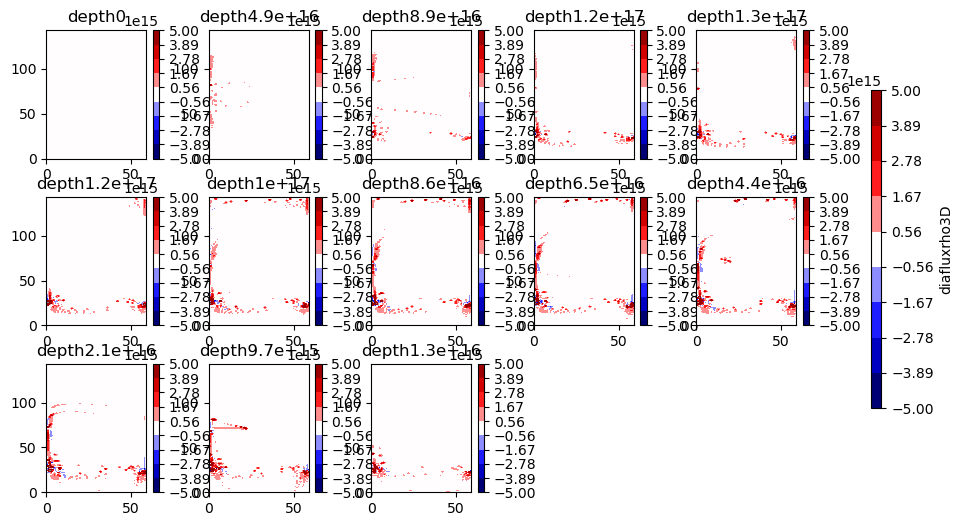

In [353]:
fig = plt.figure(figsize=(10,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diafluxrho3D[i,:,:],cmap='seismic',levels=np.linspace(-0.5e16,0.5e16,10))
    plt.colorbar()
    plt.title(f"depth{np.sum(diafluxrho3D[i,:,:]):.2g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [354]:
diaFluxOnRho_3D=np.vectorize(
    diaFluxOnRho,
    excluded=['fx','fy','fz','rhoindex0'],
    signature='()->(m,n)'
)



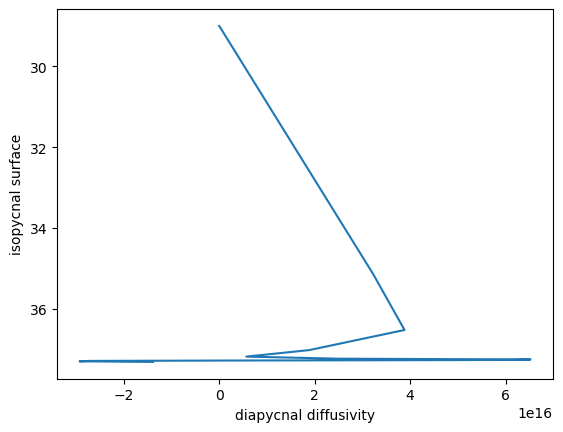

In [355]:
fdia_my=-kdia3d*agezgrad.fillna(0)*dsGM2x.rA
diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia_my.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])

plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()

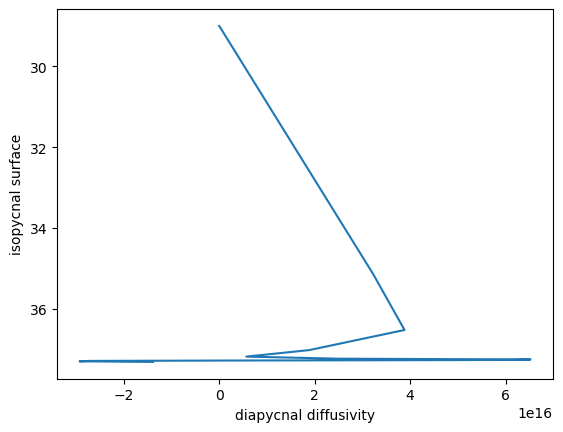

In [356]:

#agezgrad
#fdia

diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])


plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()


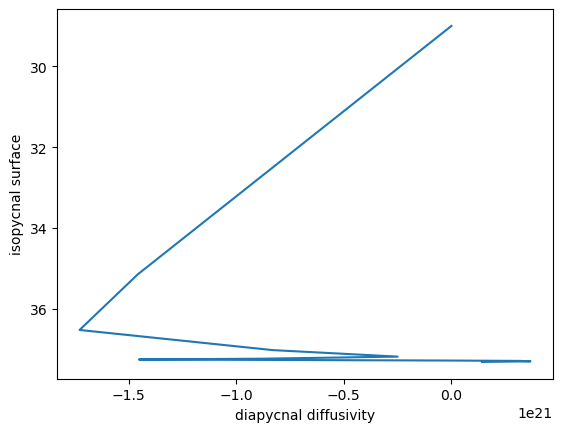

In [357]:

agezgrad_rA=agezgrad*dsGM2x.rA
agezgrad_rA=agezgrad_rA.fillna(0)
diasum_agezgrad_rA_3D=diaFluxOnRho_3D(fx=0*agezgrad_rA.load().data,fy=0*agezgrad_rA.load().data,fz=agezgrad_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diasum_agezgrad_rA_3D_hsum=np.sum(np.sum(diasum_agezgrad_rA_3D,axis=2),axis=1)
#effect_kdia=diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
plt.plot(diasum_agezgrad_rA_3D_hsum,layers1_bounds[0:Nlayersbin-1])
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()



In [358]:
kdia_infer_diainterp_2D=-diadiffflux3D/(diasum_agezgrad_rA_3D+1e-20)
kdia_infer_diainterp_2D_hsum=np.mean(np.mean(kdia_infer_diainterp_2D,axis=2),axis=1)

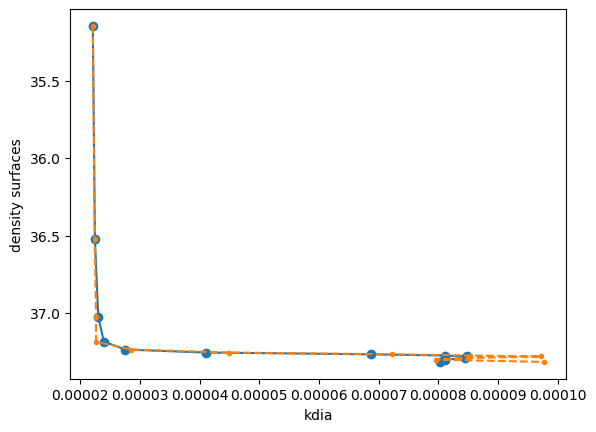

In [359]:
kdia_infer_diainterp=-diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
kdia3d_rA=kdia3d*dsGM2x.rA
rA3d=0*kdia3d+dsGM2x.rA
kdia_rA_diainterp=diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
rA_diainterp=diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
kdia_diainterp=kdia_rA_diainterp/(rA_diainterp+1e-20)
'''
This line below does not look perfectly correct,when calculating mean value,
the extra 0 values should be masked. On the other hand, 
the 0 values are not a great concern when doing sum.
'''

#Mask_kdia_diainterp=(kdia_diainterp!=0)
kdia_diainterp_hsum=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/(np.sum(np.sum(rA_diainterp+1e-30,axis=2),axis=1))

plt.plot(kdia_diainterp_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o-')
plt.plot(kdia_infer_diainterp[1:],layers1_bounds[1:Nlayersbin-1],'.--')
#plt.plot(kdia_infer_diainterp_2D_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o')

plt.xlabel('kdia')
plt.ylabel('density surfaces')
plt.gca().invert_yaxis()

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(0.5, 0.98, 'kdia isopycanl mean')

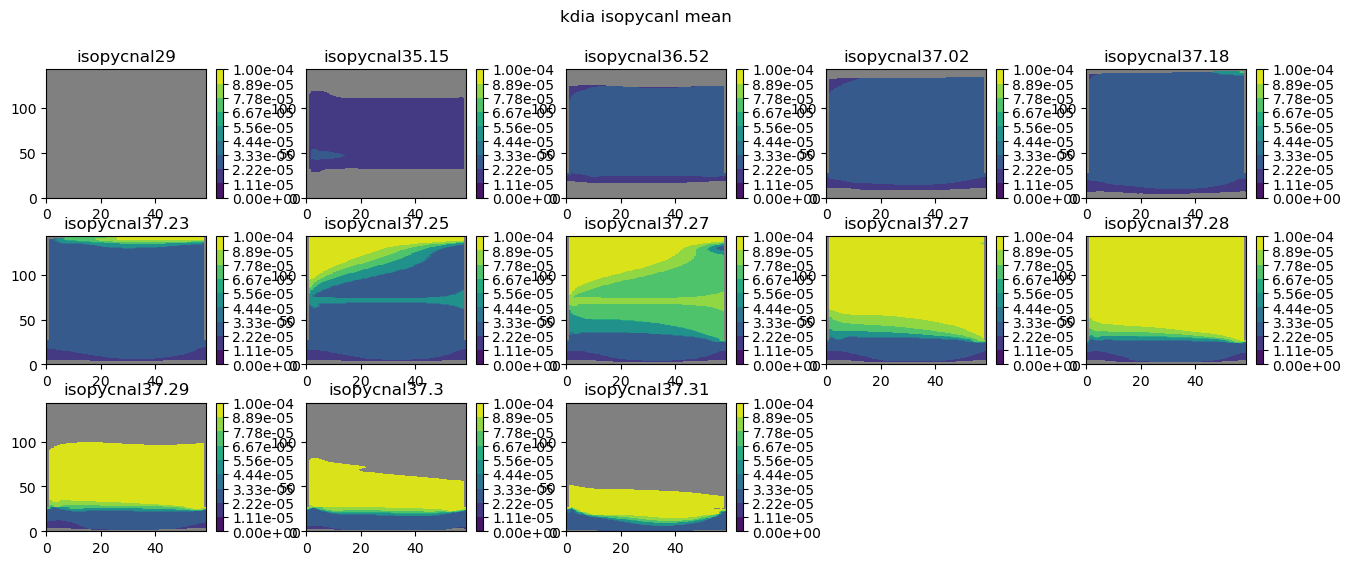

In [360]:
fig = plt.figure(figsize=(16,6))
kdia_diainterp[kdia_diainterp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(kdia_diainterp[i,:,:],levels=np.linspace(0,1e-4,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('kdia isopycanl mean')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

Text(0.5, 0.98, 'diapycanl diffusive flux on isopycnals')

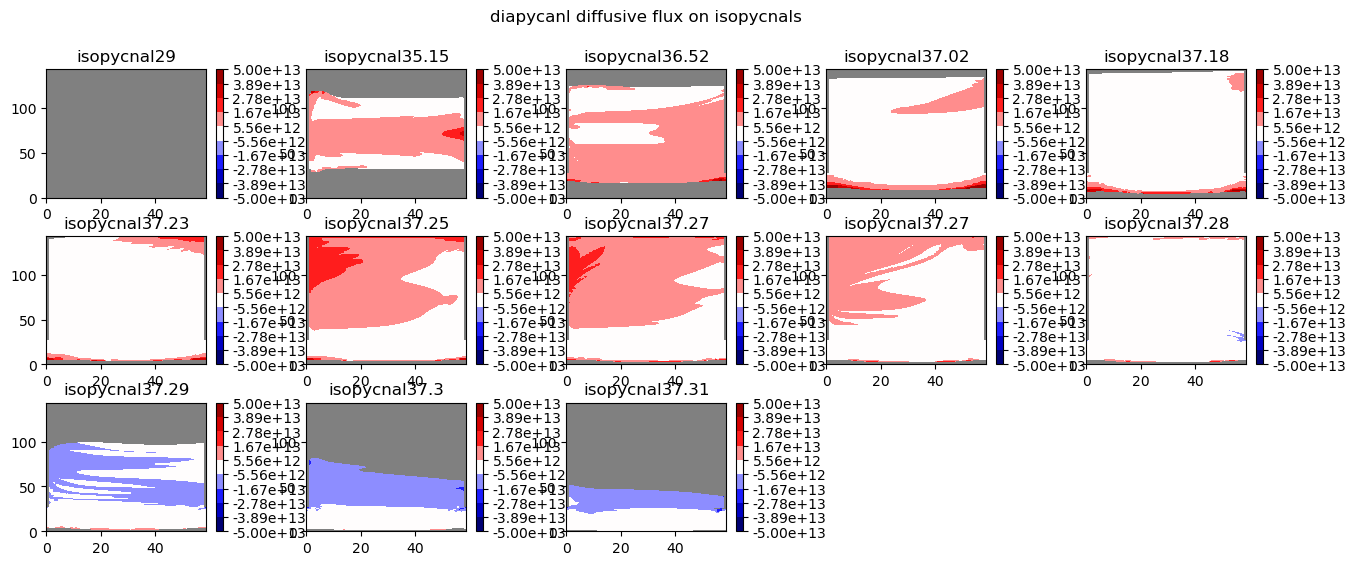

In [361]:
fig = plt.figure(figsize=(16,6))
diadiffflux3D[diadiffflux3D==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diadiffflux3D[i,:,:],cmap='seismic',levels=np.linspace(-5e13,5e13,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")
    
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycanl diffusive flux on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

Text(0.5, 0.98, 'agezgrad*rA on isopycnals')

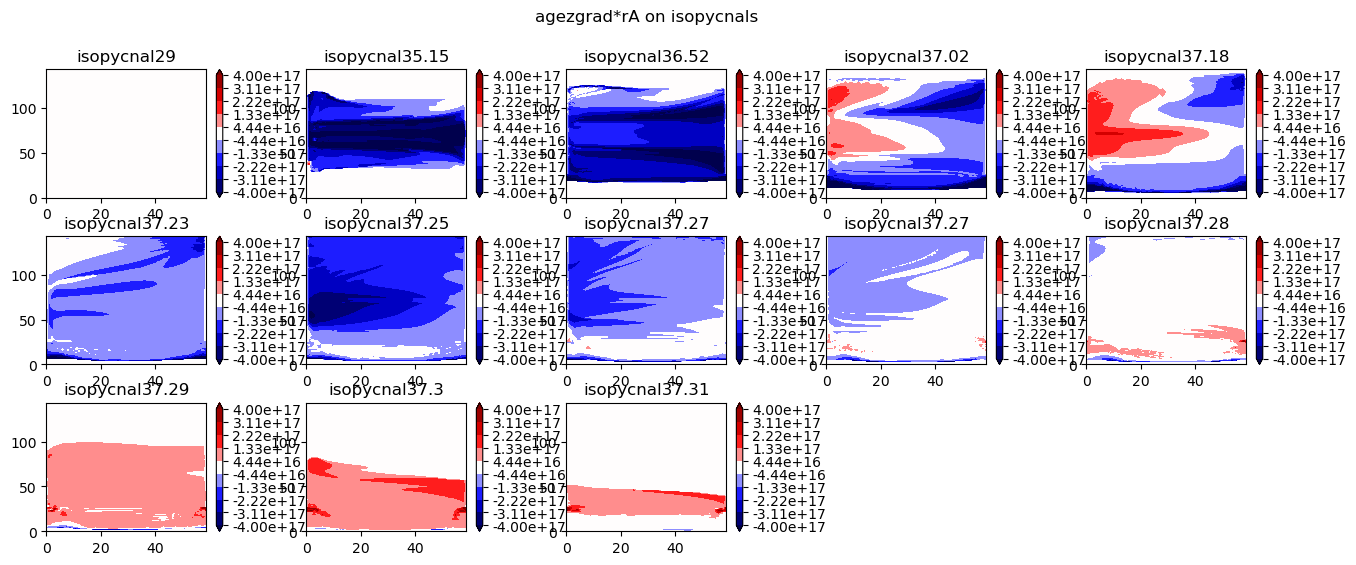

In [362]:
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diasum_agezgrad_rA_3D[i,:,:],cmap='seismic',levels=np.linspace(-4e17,4e17,10),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('agezgrad*rA on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [376]:
#mapping diapycnal diffusion back to density coordinate(to be implemented)
ugmFromSkewflux
ugmFromTensor.load()

<xarray.DataArray (Z: 30, YC: 144, XG: 60)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [            nan,             nan,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,             nan],
        [            nan,             nan,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         -3.95585690e-03, -3.76072852e-03,            -inf],
        [            nan,             inf,  9.34191485e-05, ...,
         -2.17570993e-03, -2.48124124e-03,            -inf],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,            -inf, -4.62951866e-04, ...,
         -1.61776738e-03, -9.95019567e-04,            -inf],
        [            nan,            -inf, -3.03027249e-04, ...,
         -2.46596360e-03, -1.48198078e-03,            -inf],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * YC       (YC) >f4 -71.5 -70.5 -69.5 -68.5 -67.5 ... 67.5 68.5 69.5 70.5 71.5
  * XG       (XG) >f4 0.0 1.0 2.0 3.0 4.0 5.0 ... 54.0 55.0 56.0 57.0 58.0 59.0
  * Z        (Z) >f4 -10.0 -30.0 -50.0 ... -3.375e+03 -3.625e+03 -3.875e+03
    drF      (Z) >f4 20.0 20.0 20.0 20.0 20.0 ... 250.0 250.0 250.0 250.0 250.0
    PHrefC   (Z) >f4 98.1 294.3 490.5 686.7 ... 3.311e+04 3.556e+04 3.801e+04
    rhoRef   (Z) >f4 1.028e+03 1.028e+03 1.028e+03 ... 1.044e+03 1.045e+03
    dyG      (YC, XG) >f4 1.112e+05 1.112e+05 1.112e+05 ... 1.112e+05 1.112e+05
    dxC      (YC, XG) >f4 3.528e+04 3.528e+04 3.528e+04 ... 3.528e+04 3.528e+04
    rAw      (YC, XG) >f4 3.922e+09 3.922e+09 3.922e+09 ... 3.922e+09 3.922e+09
    hFacW    (Z, YC, XG) >f4 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskW    (Z, YC, XG) bool False False False False ... False False False

<xarray.DataArray (Z: 30, YC: 144, XG: 60)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [            nan,             nan,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,             nan],
        [            nan,             nan,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         -3.95585690e-03, -3.76072852e-03,            -inf],
        [            nan,             inf,  9.34191485e-05, ...,
         -2.17570993e-03, -2.48124124e-03,            -inf],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,            -inf, -4.62951866e-04, ...,
         -1.61776738e-03, -9.95019567e-04,            -inf],
        [            nan,            -inf, -3.03027249e-04, ...,
         -2.46596360e-03, -1.48198078e-03,            -inf],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * YC       (YC) >f4 -71.5 -70.5 -69.5 -68.5 -67.5 ... 67.5 68.5 69.5 70.5 71.5
  * XG       (XG) >f4 0.0 1.0 2.0 3.0 4.0 5.0 ... 54.0 55.0 56.0 57.0 58.0 59.0
  * Z        (Z) >f4 -10.0 -30.0 -50.0 ... -3.375e+03 -3.625e+03 -3.875e+03
    drF      (Z) >f4 20.0 20.0 20.0 20.0 20.0 ... 250.0 250.0 250.0 250.0 250.0
    PHrefC   (Z) >f4 98.1 294.3 490.5 686.7 ... 3.311e+04 3.556e+04 3.801e+04
    rhoRef   (Z) >f4 1.028e+03 1.028e+03 1.028e+03 ... 1.044e+03 1.045e+03
    dyG      (YC, XG) >f4 1.112e+05 1.112e+05 1.112e+05 ... 1.112e+05 1.112e+05
    dxC      (YC, XG) >f4 3.528e+04 3.528e+04 3.528e+04 ... 3.528e+04 3.528e+04
    rAw      (YC, XG) >f4 3.922e+09 3.922e+09 3.922e+09 ... 3.922e+09 3.922e+09
    hFacW    (Z, YC, XG) >f4 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskW    (Z, YC, XG) bool False False False False ... False False False

In [383]:
fadvxtmp=fadvx
fadvytmp=fadvy
fadvrtmp=fadvr
'''
fVolx=(fadvxtmp/ageU).fillna(0)
fVoly=(fadvytmp/ageV).fillna(0)
fVolr=(fadvrtmp/agel).fillna(0)
fVolx=dsGM2x.uVeltave.mean('time')*xA
fVoly=dsGM2x.vVeltave.mean('time')*yA
fVolr=dsGM2x.wVeltave.mean('time')*dsGM2x.rA
fVolx=ugmFromSkewflux.fillna(0)*xA
fVoly=vgmFromSkewflux.fillna(0)*yA
fVolr=wgmFromSkewflux.fillna(0)*dsGM2x.rA
'''
fVolx=ugmFromTensor.fillna(0)*xA.fillna(0)
fVoly=vgmFromTensor.fillna(0)*yA.fillna(0)
fVolr=wgmFromTensor.fillna(0)*dsGM2x.rA.fillna(0)

#diaageadvfluxrho=diaFluxOnRho_3D(fx=fadvxtmp.load().data,fy=fadvytmp.load().data,fz=fadvrtmp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvfluxrho=diaFluxOnRho_3D(fx=fVolx.load().data,fy=fVoly.load().data,fz=fVolr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
#diaagerho=diaageadvfluxrho/(diaVoladvfluxrho)

diaVoladvfluxrho_hsum=np.sum(np.sum(diaVoladvfluxrho,axis=2),axis=1)
diaVoladvfluxrho_hsum



array([ 0.00000000e+00,  4.94526089e+11,  5.88513923e+11,  7.73960909e+11,
        7.12216302e+11,  8.56847126e+11,  6.36072488e+11,  5.44314322e+11,
        5.81224941e+11,  7.43053944e+11,  5.52108300e+11,  2.10705683e+11,
       -1.53166937e+11])

In [365]:
agetmean=diaagerho/31104000
wVolumetmean=diaVoladvfluxrho.copy()
wVolumepos=wVolumetmean.copy()
wVolumepos[wVolumetmean<=0]=0
wVolumeneg=wVolumetmean.copy()
wVolumeneg[wVolumetmean>=0]=0
agepos=agetmean.copy()
agepos[wVolumetmean<=0]=0
ageneg=agetmean.copy()
ageneg[wVolumetmean>=0]=0
#wVolumeneg=wVolumetmean[wVolumetmean<0]
#ageneg=agetmean[wVolumetmean<0]

#agepos_areamean=grid.average(agepos,['X','Y'])
#ageneg_areamean=grid.average(ageneg,['X','Y'])
'''
agepos_fluxmean=grid.average(agepos*wVolumepos,['X','Y'])/grid.average(wVolumepos,['X','Y'])
ageneg_fluxmean=grid.average(ageneg*wVolumeneg,['X','Y'])/grid.average(wVolumeneg,['X','Y'])
deltaage_flux=-(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=-(ageneg_areamean-agepos_areamean)
agepos_areamean.plot(y='Zl',label='ageup_area')
agepos_fluxmean.plot(y='Zl',label='ageup_flux')
ageneg_areamean.plot(y='Zl',label='agedown_area')
ageneg_fluxmean.plot(y='Zl',label='agedown_flux')
deltaage_flux.plot(y='Zl',label='deltaage_flux')
deltaage_area.plot(y='Zl',label='deltaage_area')
plt.legend()
'''
ageneg

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(0.5, 0.98, 'agezgrad*rA on isopycnals')

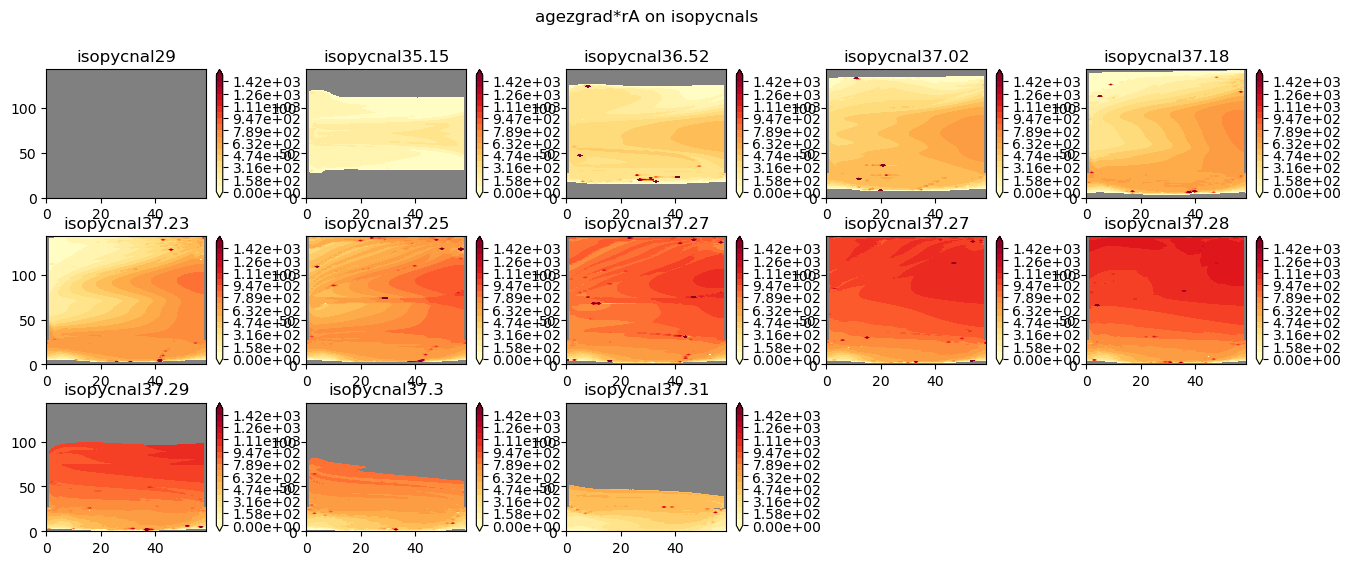

In [366]:
agetmean=diaagerho.copy()/31104000
agetmean[agetmean==0]=np.nan
#agetmean[diaVoladvfluxrho<=1e-20]=np.nan
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(agetmean[i,:,:],cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('agezgrad*rA on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [367]:
Voldata=Vol.transpose('Z','YC','XC').load().data
def rhoInt(Xdata,rhoindex=rhoindex,Nlayersbin=Nlayersbin):
    ''''''
    'Integrate Xdata at density layers'
    ''''''
    dX_rho=np.zeros([Nlayersbin-1,1])
    for idx in range(Nx):
        for idy in range(Ny):
            for idz in range(Nz): 
                rhoindextemp=rhoindex[idz,idy,idx]
                if(~np.isnan(rhoindextemp)):  
                    dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]

    #sumVol_rho=np.cumsum(dVol_rho[::-1])[::-1] 
    return np.cumsum(dX_rho[::-1])[::-1]


sumVol_rho=rhoInt(Voldata)
#sumdivtoty_rho=rhoInt(divtoty.load().data)
#sumdivtotx_rho=rhoInt(divtotx.load().data)
#sumdivtotr_rho=rhoInt(divtotr.load().data)
#sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
sumdivtot_rho=rhoInt(divtot.load().data)
#sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
sumdivadv_rho=rhoInt(divadv.load().data)
sumdivGM_rho=rhoInt(divGM.load().data)
sumdivRedi_rho=rhoInt(divRedi.load().data)
sumdivconv_rho=rhoInt(divconv.load().data)
sumdivdia_rho=rhoInt(divdia.load().data)
sumfsurf_rho=rhoInt(fsurf.load().data)





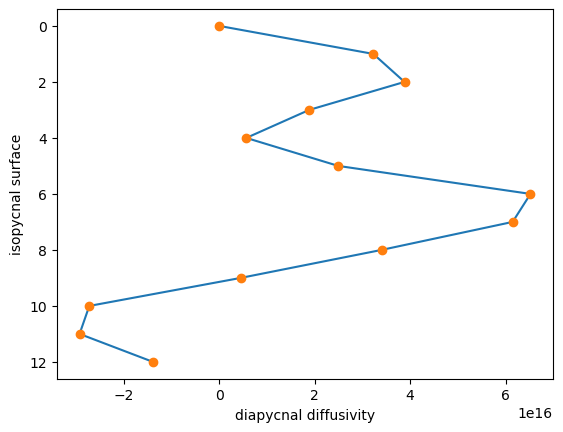

In [368]:
plt.plot(sumdivdia_rho,np.r_[0:Nlayersbin-1],label='dia flux')
plt.plot(diadiffflux_hsum,np.r_[0:Nlayersbin-1],'o',label='dia flux')

sumdivdia_rho
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()

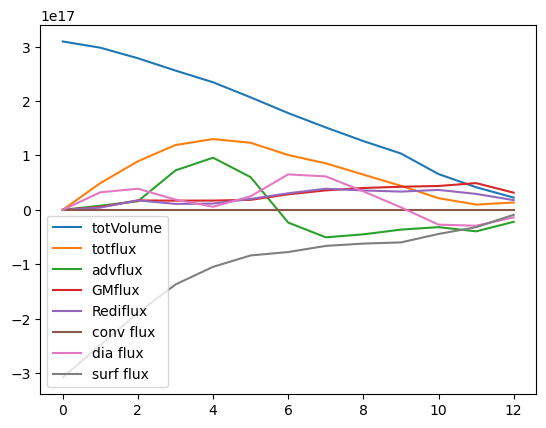

In [369]:
plt.plot(sumVol_rho,label='totVolume')
plt.plot(sumdivtot_rho,label='totflux')
plt.plot(sumdivadv_rho,label='advflux')
plt.plot(sumdivGM_rho,label='GMflux')
plt.plot(sumdivRedi_rho,label='Rediflux')
plt.plot(sumdivconv_rho,label='conv flux')
plt.plot(sumdivdia_rho,label='dia flux')
plt.plot(sumfsurf_rho,label='surf flux')
plt.legend()
#plt.plot(-sumdivtotydiag_rho)
#plt.plot(sumdivtoty_rho+sumdivtotx_rho+sumdivtotr_rho-sumfsurf_rho)

#plt.plot(-sumdivtot1_rho-sumfsurf_rho)

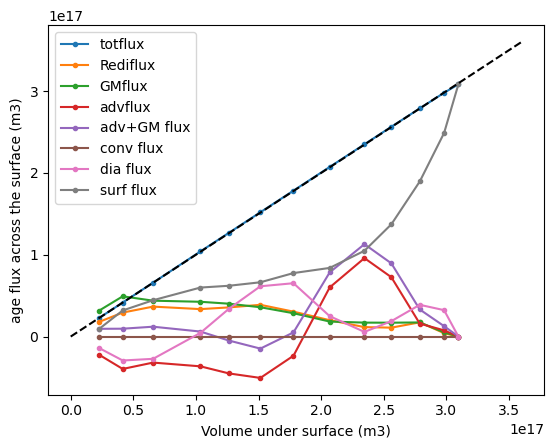

In [370]:
plt.plot(sumVol_rho,sumdivtot_rho-sumfsurf_rho,'.-',label='totflux')
plt.plot(sumVol_rho,sumdivRedi_rho,'.-',label='Rediflux')
plt.plot(sumVol_rho,sumdivGM_rho,'.-',label='GMflux')
plt.plot(sumVol_rho,sumdivadv_rho,'.-',label='advflux')
plt.plot(sumVol_rho,sumdivGM_rho+sumdivadv_rho,'.-',label='adv+GM flux')
plt.plot(sumVol_rho,sumdivconv_rho,'.-',label='conv flux')
plt.plot(sumVol_rho,sumdivdia_rho,'.-',label='dia flux')
plt.plot(sumVol_rho,-sumfsurf_rho,'.-',label='surf flux')
plt.plot([0,3.6e17],[0,3.6e17],'k--')

plt.xlabel('Volume under surface (m3)')
plt.ylabel('age flux across the surface (m3)')
plt.legend()

In [371]:
divtot_rhosum=divtot_rho.sum('XC').sum('YC')
divtot_rhosum=divtot_rhosum[::-1].cumsum('rho_coord')[::-1]
Vol_rhosum=Vol_rho.sum('XC').sum('YC')
Vol_rhosum=Vol_rhosum[::-1].cumsum('rho_coord')[::-1]
fsurf_rhosum=fsurf_rho.sum('XC').sum('YC')
fsurf_rhosum=fsurf_rhosum[::-1].cumsum('rho_coord')[::-1]
divtot_rhosum.plot()
Vol_rhosum.plot()
(divtot_rhosum-fsurf_rhosum).plot()

NameError: name 'divtot_rho' is not defined

In [ ]:
divconv